In [8]:
import numpy as np
import pandas as pd
import tqdm
import scipy
import random
from cycler import cycler
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader

import snntorch as snn
from snntorch import surrogate, utils, functional as SF

import warnings
warnings.filterwarnings("ignore")

from params import params_cae, params_snn, params_train
import utils_ext
import train_utils_ext
import network

torch.manual_seed(22)

%reload_ext autoreload
%autoreload 2

### Load train, validation and test dataset and create Data Loader

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

train_dataset = torch.load('data/train_dataset.pt')#, map_location=torch.device(device))
val_dataset = torch.load('data/val_dataset.pt')#, map_location=torch.device(device))
test_dataset = torch.load('data/test_dataset.pt')#, map_location=torch.device(device))

batch = 8
train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True, num_workers=2)
val_loader =  DataLoader(val_dataset, batch_size=batch)
test_loader = DataLoader(test_dataset, batch_size=1)

Using cpu device


In [4]:
print(f"Number of elements in train set: {len(train_dataset)}.")
print(f"Number of elements in valid set:  {len(val_dataset)}.")
print(f"Number of elements in test set:   {len(test_dataset)}.")

Number of elements in train set: 935.
Number of elements in valid set:  88.
Number of elements in test set:   89.


## Plot some examples

In [6]:
ACTIVITIES = [
    "WALKING",
    "RUNNING",
    "SITTING",
    "HANDS",
]
class_enc = {a:np.eye(len(ACTIVITIES))[i] for i, a in enumerate(ACTIVITIES)}
class_dec = {tuple(v): k for k, v in class_enc.items()}
class_dec

{(1.0, 0.0, 0.0, 0.0): 'WALKING',
 (0.0, 1.0, 0.0, 0.0): 'RUNNING',
 (0.0, 0.0, 1.0, 0.0): 'SITTING',
 (0.0, 0.0, 0.0, 1.0): 'HANDS'}

In [4]:
ACTIVITIES = [
    "WALKING",
    "RUNNING",
    "SITTING",
    "HANDS",
]
class_enc = {a:[i] for i, a in enumerate(ACTIVITIES)}
class_dec = {int(v[0]): k for k, v in class_enc.items()}
class_dec

{0: 'WALKING', 1: 'RUNNING', 2: 'SITTING', 3: 'HANDS'}

### Some Plots

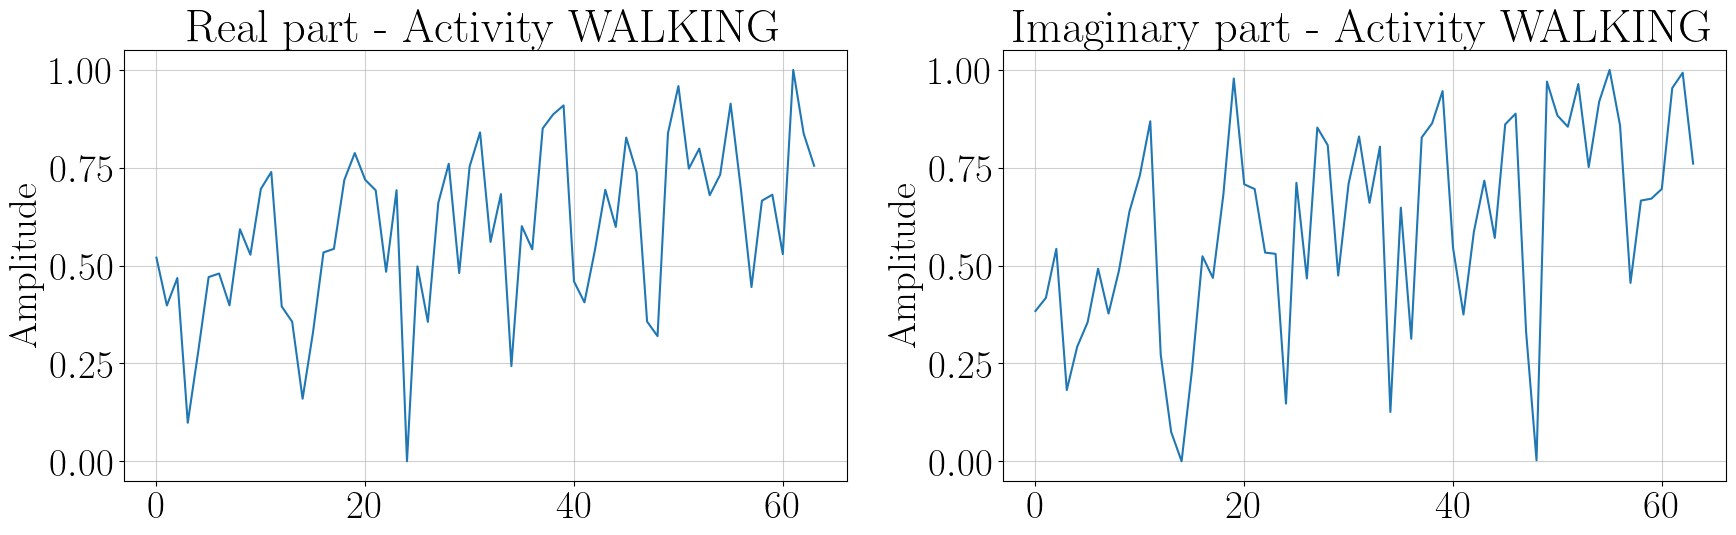

CIR shape: torch.Size([2, 232, 10, 64])


In [6]:
i = np.random.randint(0, len(train_dataset))
X, Y = train_dataset[i][0], train_dataset[i][2]

fig, ax = plt.subplots(1, 2, figsize=(18,6))

plt.subplot(121)
plt.plot(X[0,0,0,:].cpu().numpy())
plt.ylabel('Amplitude')
plt.title(f"Real part - Activity {class_dec[int(Y)]}")
plt.grid()

plt.subplot(122)
plt.plot(X[0,0,1,:].cpu().numpy())
plt.ylabel('Amplitude')
plt.title(f"Imaginary part - Activity {class_dec[int(Y)]}")
plt.grid()
plt.tight_layout()

#plt.savefig('Signal_example1.png')
plt.show()

print(f"CIR shape: {X.shape}")

The CIR has shape ($N$, $R$, $2$, $K$), where:

- $N$ is the number of windows;
- $R$ is the number of range bins, in this case: $R=10$;
- $2$ is the number of convolutional channels (one for the real part of the CIR, one for the imaginary part);
- $K$ is the length of each windows, in this case: $K=64$.

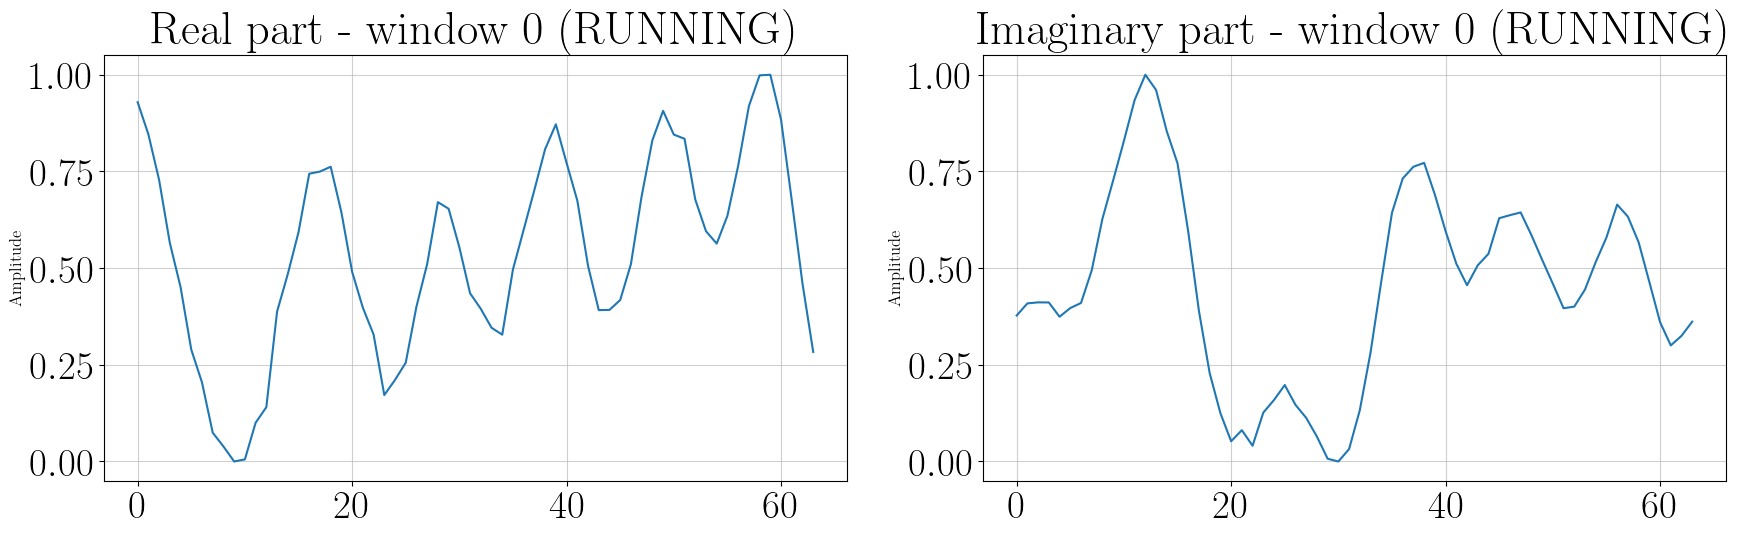

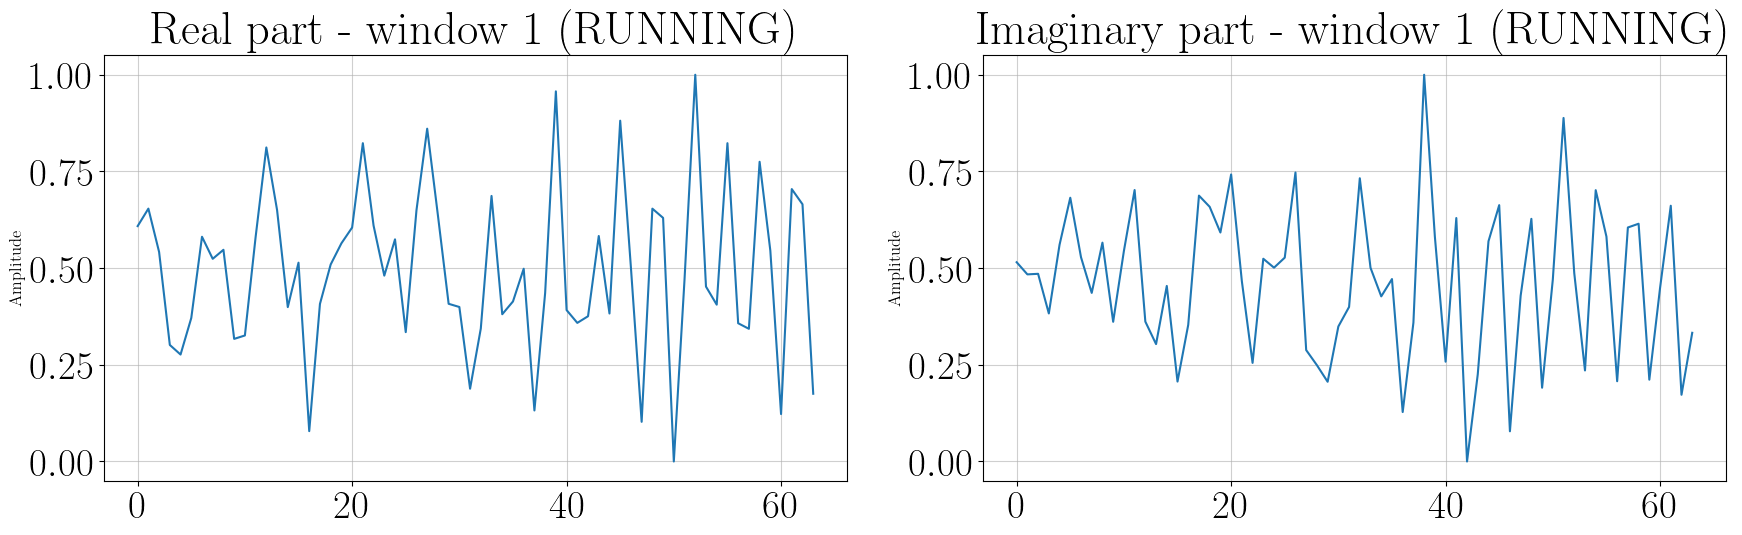

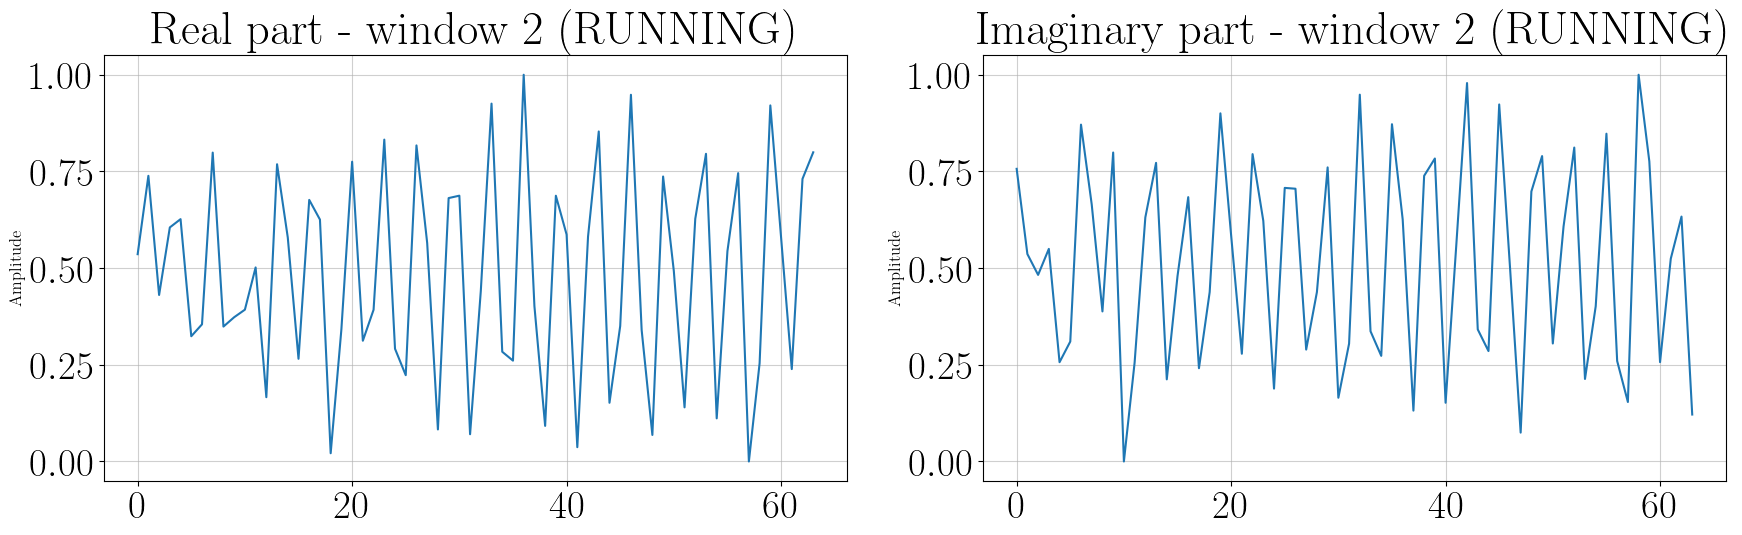

In [7]:
i = np.random.randint(0, len(train_dataset))
X, Y = train_dataset[i][0],train_dataset[i][-1]

for w in range(3):
    fig, ax = plt.subplots(1, 2, figsize=(18,6))

    plt.subplot(121)
    plt.plot(X[0, w, 0,:].cpu().numpy())
    plt.ylabel('Amplitude', fontsize=12)
    plt.title(f"Real part - window {w} ({class_dec[int(Y)]})")
    plt.grid()

    plt.subplot(122)
    plt.plot(X[1, w, 0,:].cpu().numpy())
    plt.ylabel('Amplitude',  fontsize=12)
    plt.title(f"Imaginary part - window {w} ({class_dec[int(Y)]})")
    plt.grid()
    plt.tight_layout()

    #plt.savefig('Signal_example1.png')
    plt.show()

In [167]:
for batch, X in enumerate(train_loader):
    print(X[0].shape)
    print(X[2].shape)
    break

torch.Size([32, 2, 232, 10, 64])
torch.Size([32, 1])


### Input correlation

In [8]:
corr_input = []

for X, _, _ in tqdm.tqdm(train_dataset):

    for w in range(X.shape[1]):
        for b in range(X.shape[2]):

            corr_input.append(np.corrcoef(X[0][w][b], X[1][w][b])[0,1])

  0%|          | 0/935 [00:00<?, ?it/s]

100%|██████████| 935/935 [02:13<00:00,  7.01it/s]


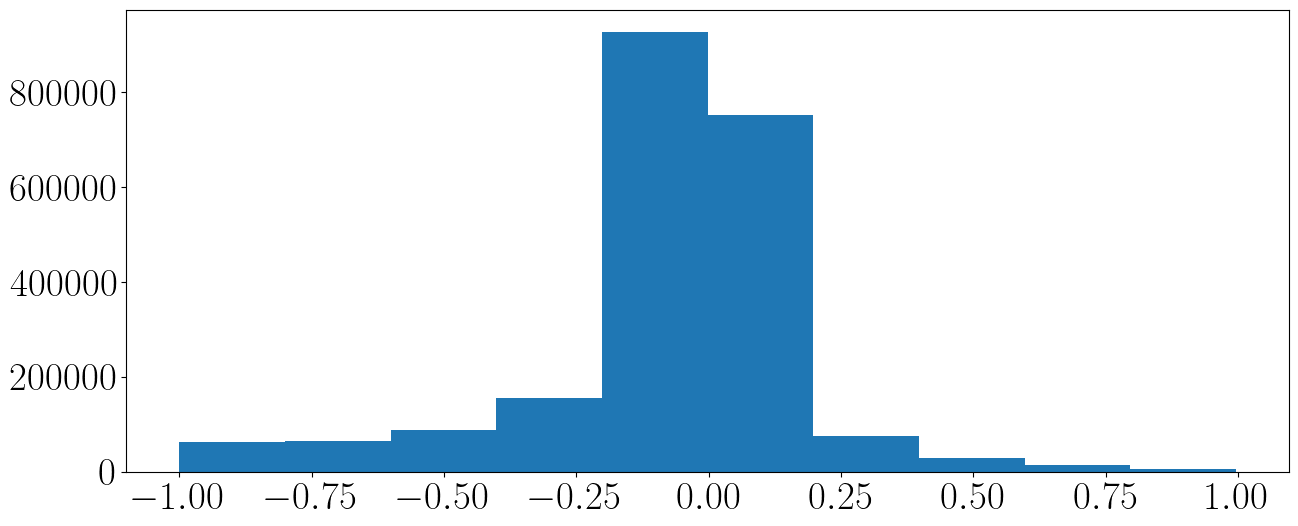

In [9]:
plt.hist(corr_input)
plt.show()

## Hyperparameter optimization

In [4]:
class LSE(nn.Module):
    def __init__(self, autoencoder, snn):
        super(LSE, self).__init__()

        self.autoencoder = autoencoder
        self.snn = snn

    def forward(self, x):
        encoded, decoded = self.autoencoder(x)
        #print(encoded.shape)
        clss = self.snn(encoded)
        #print("Class: ", clss.shape)
        
        return encoded, decoded, clss

### 1. # Conv. layers in the CAE

In [ ]:
val_mse_layers = []

snn =  network.snn_1(
                    input_dim = 2*10*64, hidden = params_snn['hidden_layers'], 
                    n_classes = params_snn['num_classes'], 
                    surr_grad = params_snn['surrogate_grad'],
                    learn_thr = params_snn['learn_thr'], 
                    learn_beta = params_snn['learn_beta']
                    ).to(device)

# CAE with 2 layers
autoencoder = network.cae_2(
                            tau = params_cae['tau'], 
                            channels = params_cae['feature_maps'], 
                            kernel_size = params_cae['kernel'], 
                            stride = params_cae['stride'], padding = params_cae['padding']
                            ).to(device)

net = LSE(autoencoder, snn).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr = params_train['l_rate'])

train_loss, val_loss, train_acc, val_acc, cae_loss, snn_loss = train_utils_ext.train(
                                                    model = net, 
                                                    train = train_loader, valid = val_loader,
                                                    loss_fn_cae = params_cae['loss_fn'], 
                                                    out_dec = params_snn['output_decoding'],
                                                    optimizer = optimizer, 
                                                    acc_steps = params_train['acc_steps'],
                                                    alfa = params_train['alpha'], 
                                                    beta = params_train['beta'], 
                                                    Lambda = params_train['lambda_reg'], 
                                                    epochs = params_train['epochs'], 
                                                    patience = params_train['patience'], 
                                                    path = None)

val_mse_layers.append(np.mean(val_loss))

autoencoder = autoencoder.cpu()
net = net.cpu()

del autoencoder, optimizer, net
torch.cuda.empty_cache()

# CAE with 3 layers
autoencoder = network.cae_3(
                            theta = params_cae['tau'], 
                            channels = params_cae['feature_maps'], 
                            kernel_size = params_cae['kernel'], 
                            stride = params_cae['stride'], padding = params_cae['padding']
                            ).to(device)
    
net = LSE(autoencoder, snn).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr = params_train['l_rate'])

train_loss1, val_loss1, train_acc1, val_acc1, cae_loss1, snn_loss1 = train_utils_ext.train(
                                                        model = net, 
                                                        train = train_loader, valid = val_loader,
                                                        loss_fn_cae = params_cae['loss_fn'], 
                                                        out_dec = params_snn['output_decoding'],
                                                        optimizer = optimizer, 
                                                        acc_steps = params_train['acc_steps'],
                                                        alfa = params_train['alpha'], 
                                                        beta = params_train['beta'], 
                                                        Lambda = params_train['lambda_reg'], 
                                                        epochs = params_train['epochs'], 
                                                        patience = params_train['patience'], 
                                                        path = None)
val_mse_layers.append(np.mean(val_loss1))

In [17]:
model_parameters = filter(lambda p: p.requires_grad, autoencoder.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

1932

In [ ]:
print(torch.cuda.memory_summary())

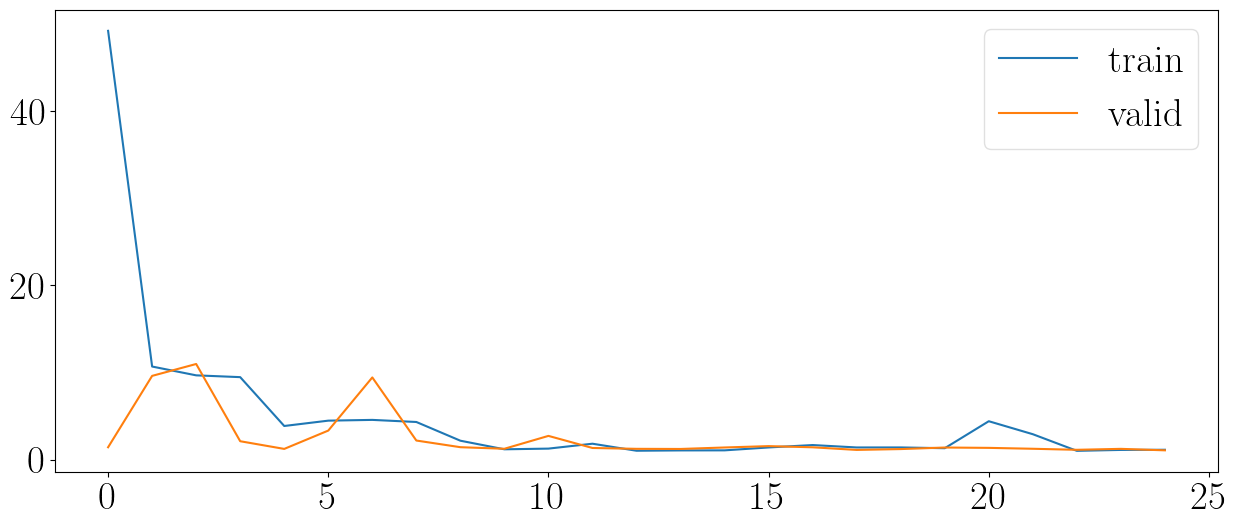

In [13]:
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='valid')
#plt.xticks(np.arange(epochs), labels=np.arange(epochs)+1)
plt.legend()
plt.show()

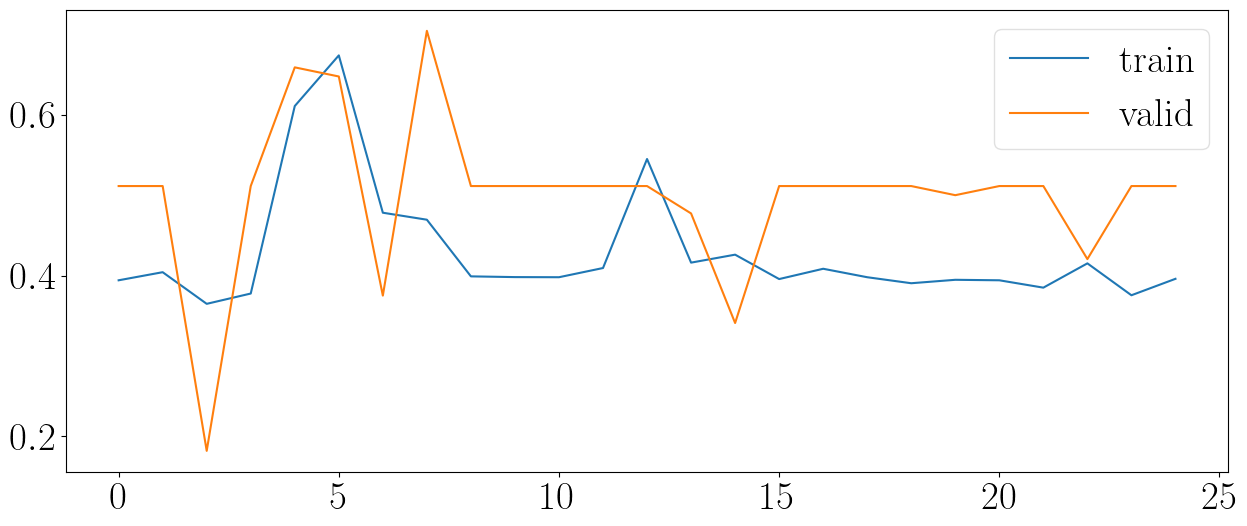

In [14]:
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='valid')
#plt.xticks(np.arange(epochs), labels=np.arange(epochs)+1)
plt.legend()
plt.show()

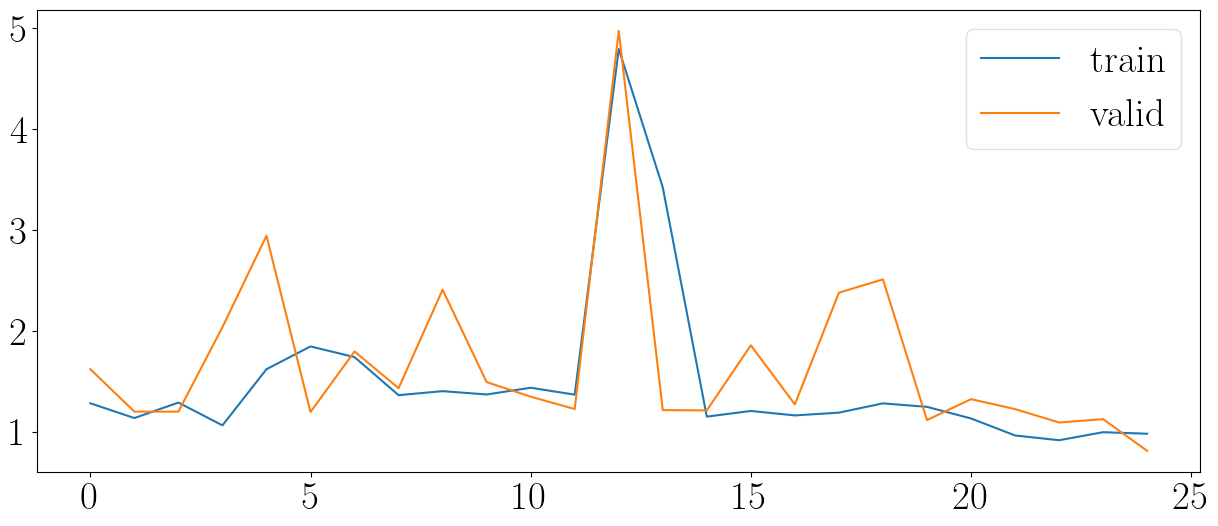

In [15]:
plt.plot(train_loss1, label='train')
plt.plot(val_loss1, label='valid')
#plt.xticks(np.arange(epochs), labels=np.arange(epochs)+1)
plt.legend()
plt.show()

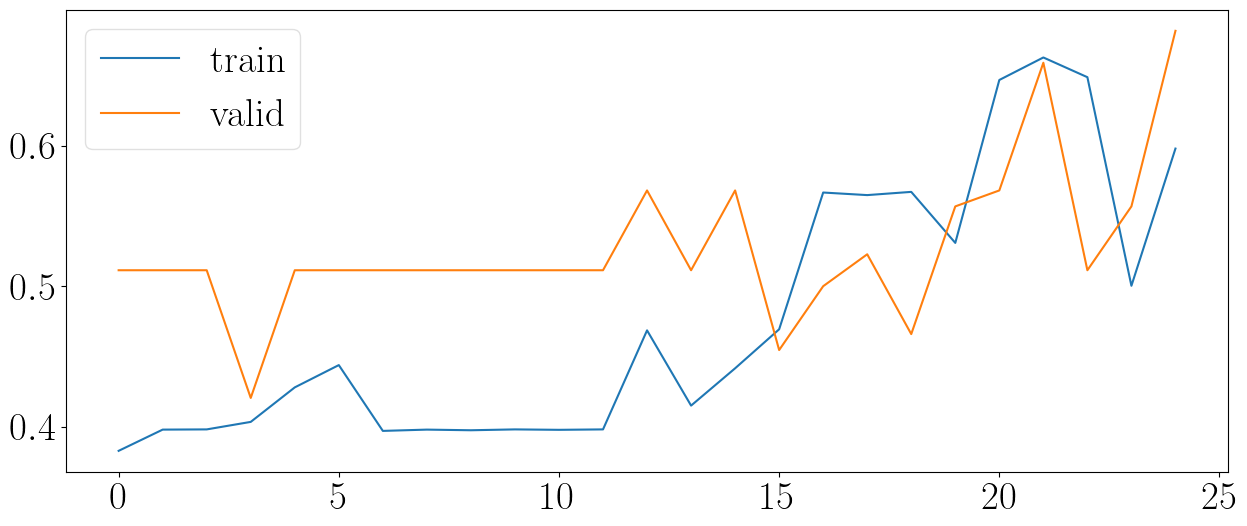

In [16]:
plt.plot(train_acc1, label='train')
plt.plot(val_acc1, label='valid')
#plt.xticks(np.arange(epochs), labels=np.arange(epochs)+1)
plt.legend()
plt.show()

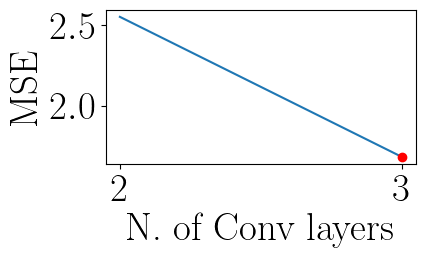

In [25]:
ind_min_nl = np.argmin(val_mse_layers)
plt.figure(figsize=(4,2))
plt.plot(val_mse_layers)
plt.plot(ind_min_nl, val_mse_layers[ind_min_nl], marker='o', color='red')
plt.xticks([0,1], ['2', '3'])
plt.xlabel('N. of Conv layers')
plt.ylabel('MSE')
plt.show()

### 2. Number of channels

In [ ]:
channels = [[64,32], [128,64], [256,128]]
val_mse_channels = []
train_losses, val_losses = [], []
train_accs, val_accs = [], []
cae_losses, snn_losses = [],  []

snn =  network.snn_1(
                    input_dim = 2*10*64, hidden = params_snn['hidden_layers'], 
                    n_classes = params_snn['num_classes'], 
                    surr_grad = params_snn['surrogate_grad'],
                    learn_thr = params_snn['learn_thr'], 
                    learn_beta = params_snn['learn_beta']
                    ).to(device)

for ch in channels:
    autoencoder = network.cae_3(
                            tau = params_cae['tau'], 
                            channels = params_cae['feature_maps'], 
                            kernel_size = params_cae['kernel'], 
                            stride = params_cae['stride'], padding = params_cae['padding']
                            ).to(device)
    
    net = LSE(autoencoder, snn).to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr = params_train['l_rate'])

    train_loss, val_loss, train_acc, val_acc, cae_loss, snn_loss = train_utils_ext.train(
                                                        model = net, 
                                                        train = train_loader, 
                                                        valid = val_loader,
                                                        loss_fn_cae = params_cae['loss_fn'], 
                                                        out_dec = params_snn['output_decoding'],
                                                        optimizer = optimizer, 
                                                        acc_steps = params_train['acc_steps'],
                                                        alfa = params_train['alpha'], 
                                                        beta = params_train['beta'], 
                                                        Lambda = params_train['lambda_reg'], 
                                                        epochs = params_train['epochs'], 
                                                        patience = params_train['patience'], 
                                                        path = None)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    cae_losses.append(cae_loss)
    snn_losses.append(snn_loss)
    val_mse_channels.append(np.mean(val_loss))

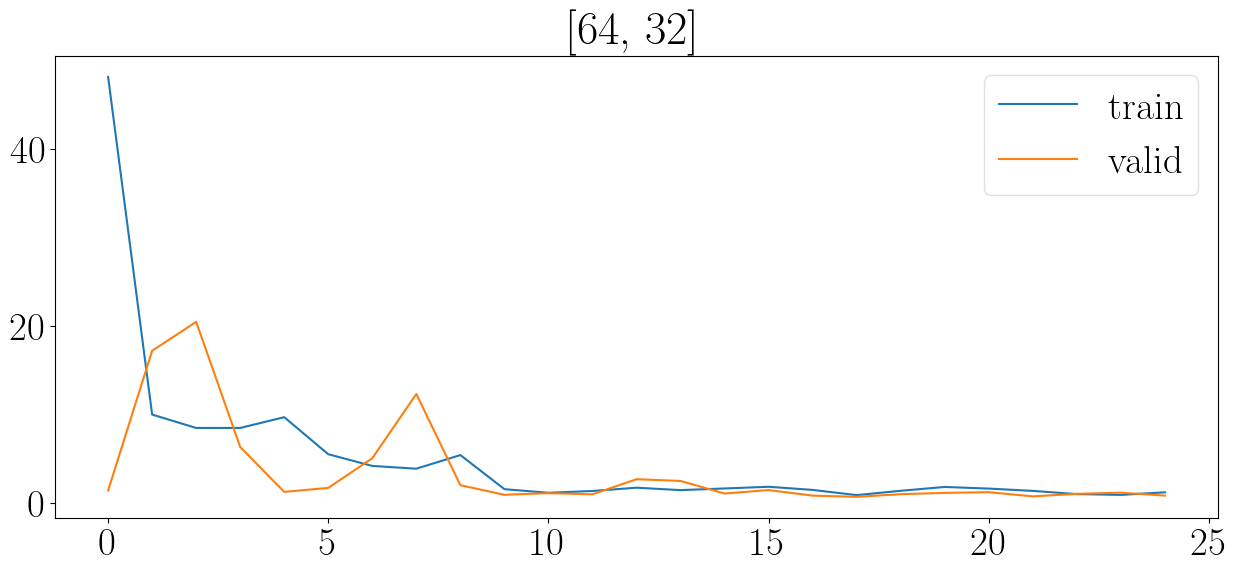

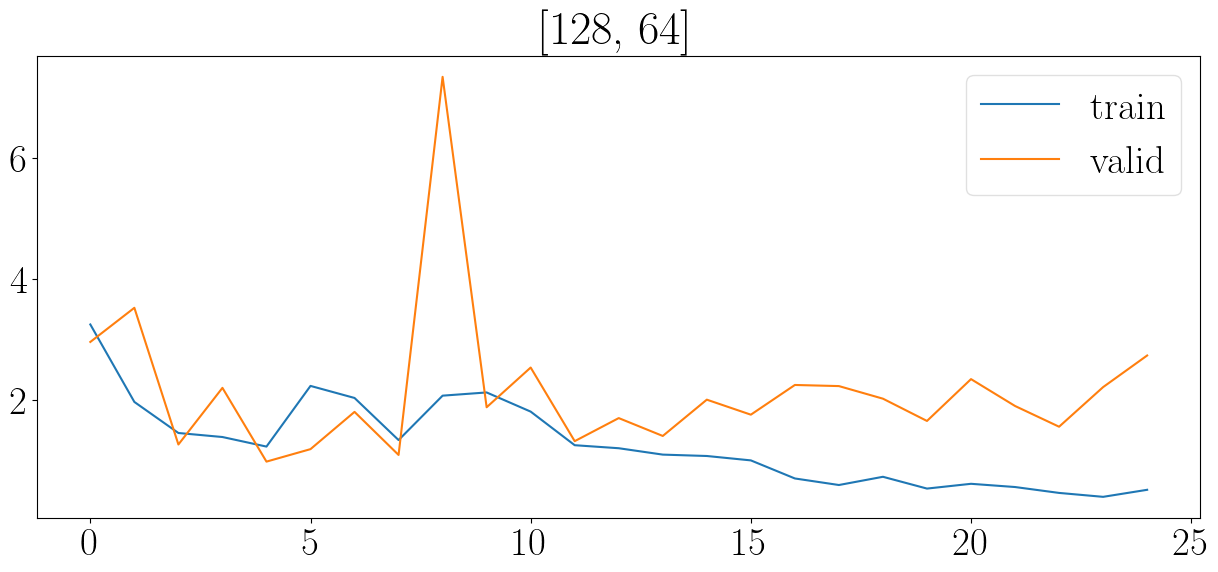

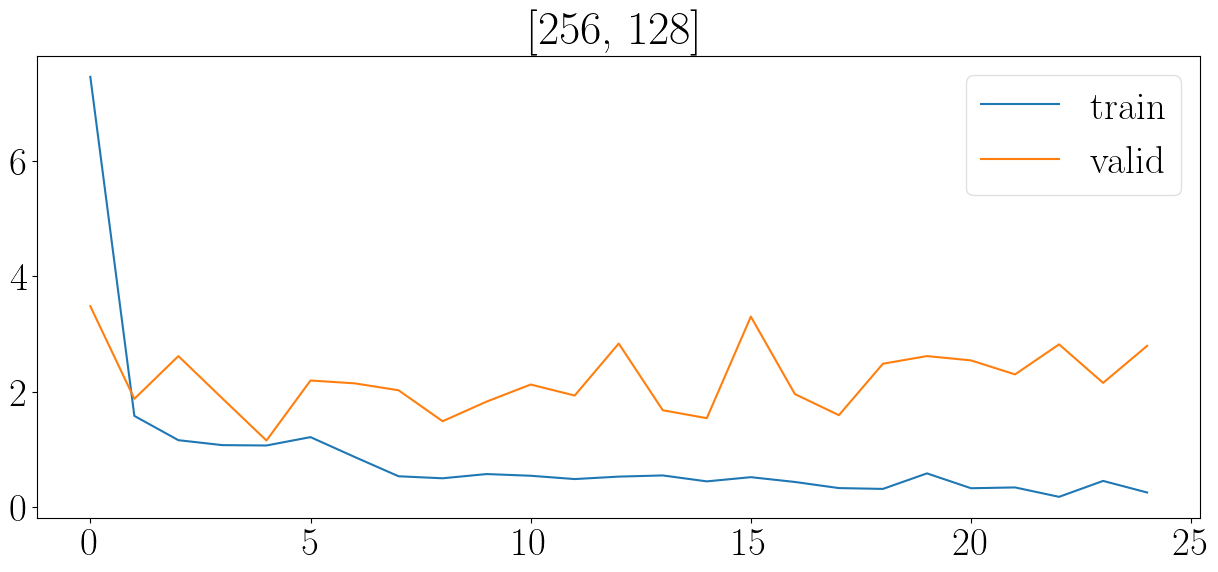

In [17]:
for i in range(len(train_losses)):
    plt.plot(train_losses[i], label='train')
    plt.plot(val_losses[i], label='valid')
    plt.title(str(channels[i]))
    plt.legend()
    plt.show()

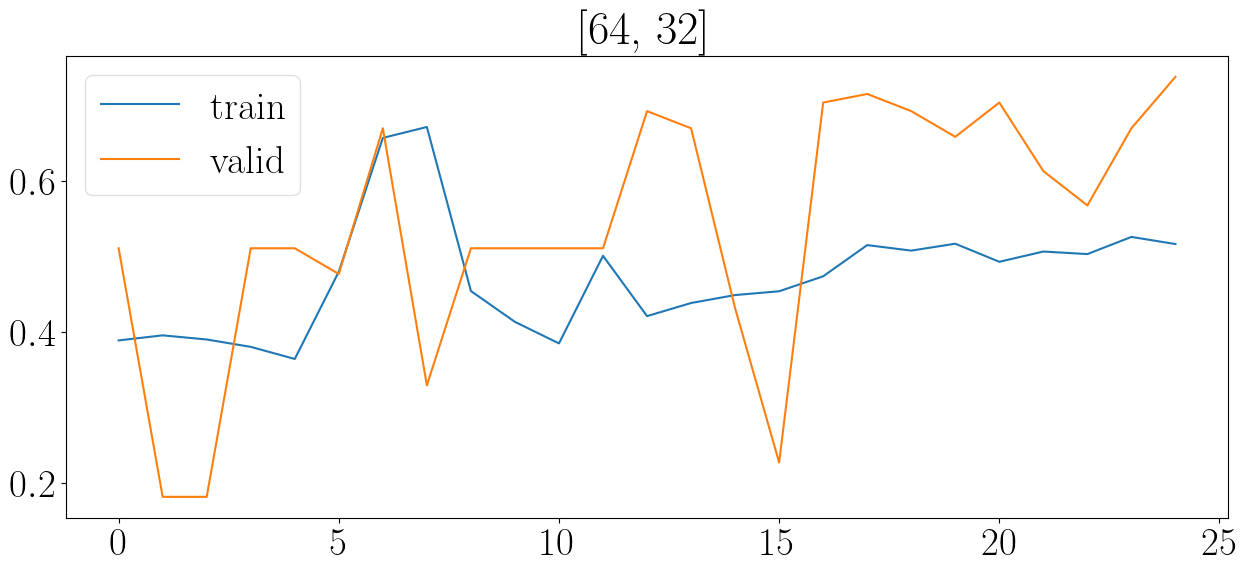

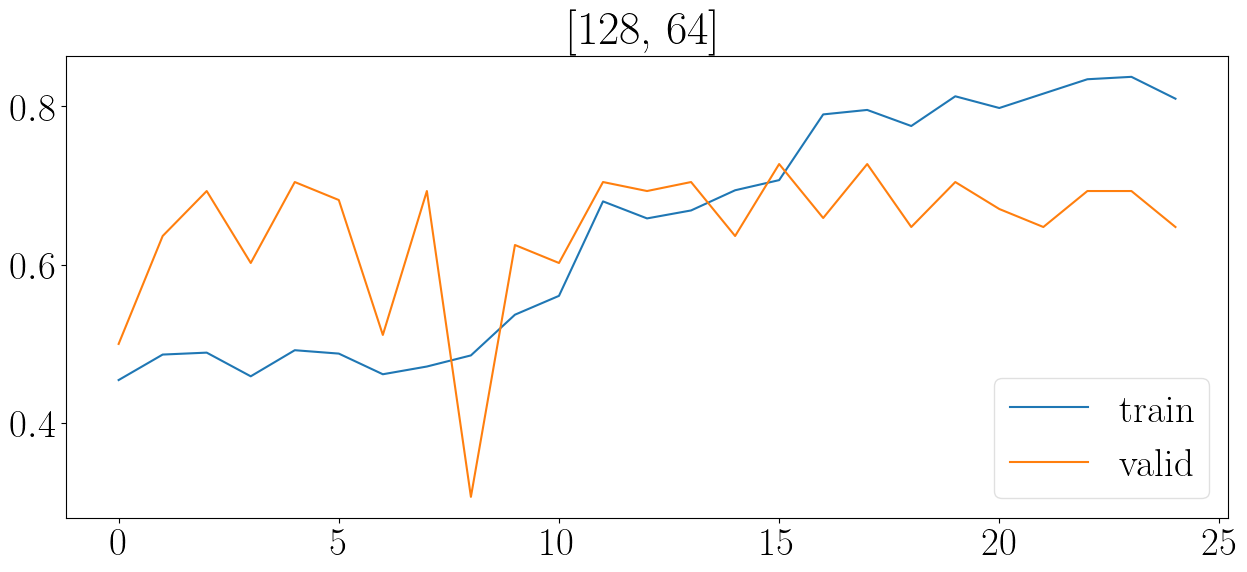

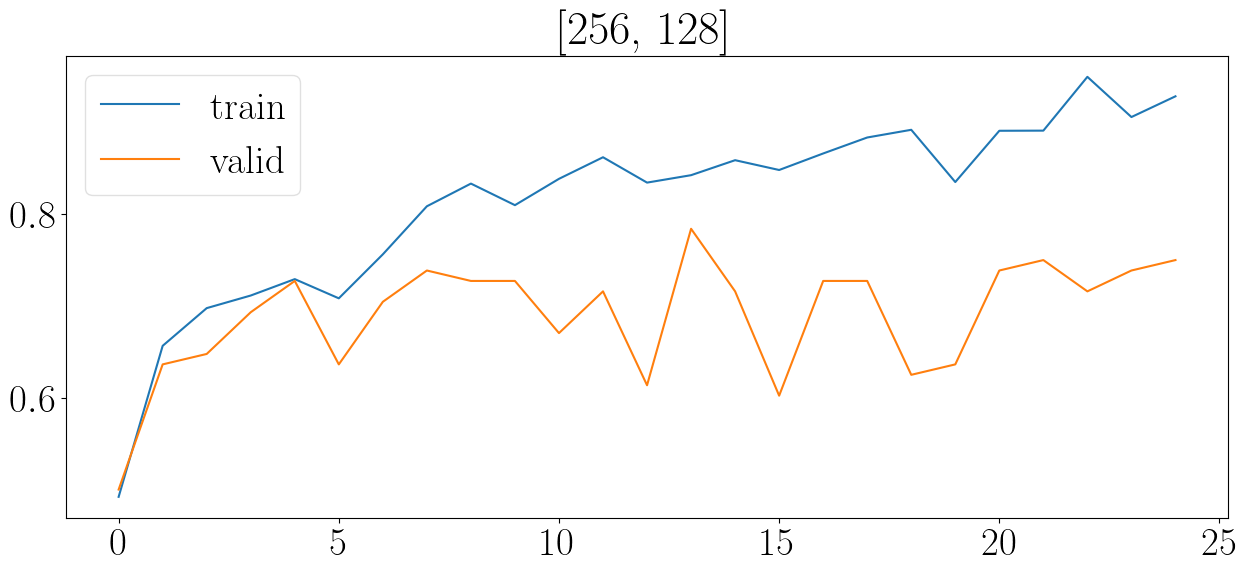

In [18]:
for i in range(len(train_accs)):
    plt.plot(train_accs[i], label='train')
    plt.plot(val_accs[i], label='valid')
    plt.title(str(channels[i]))
    plt.legend()
    plt.show()

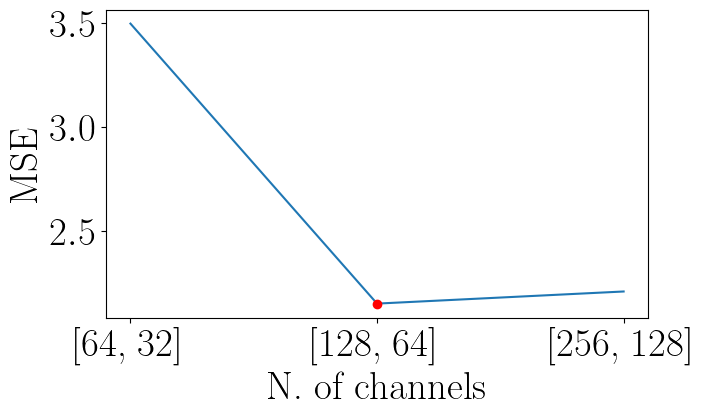

In [13]:
ind_min_ch = np.argmin(val_mse_channels)
plt.figure(figsize=(7,4))
plt.plot(val_mse_channels)
plt.plot(ind_min_ch, val_mse_channels[ind_min_ch], marker='o', color='red')
plt.xticks(np.arange(len(channels)), channels)
plt.xlabel('N. of channels')
plt.ylabel('MSE')
plt.show()

In [7]:
channels_ = []
if channels[ind_min_ch][0]==64:
    channels_ = [[64, 64], [128, 64], [64, 128]]

elif channels[ind_min_ch][0]==128:
    channels_ = [[64, 128], [128, 64], [128, 128]]

else:
    channels_ = [[128, 256], [256, 128], [256, 256]]

channels_

[[64, 128], [128, 64], [128, 128]]

In [ ]:
channels = [[64,128], [128,64], [128,128]]
val_mse_channels = []
train_losses, val_losses = [], []
train_accs, val_accs = [], []
cae_losses, snn_losses = [],  []

snn =  network.snn_1(
                    input_dim = 2*10*64, hidden = params_snn['hidden_layers'], 
                    n_classes = params_snn['num_classes'], 
                    surr_grad = params_snn['surrogate_grad'],
                    learn_thr = params_snn['learn_thr'], 
                    learn_beta = params_snn['learn_beta']
                    ).to(device)

for ch in channels:
    autoencoder = network.cae_3(
                            theta = params_cae['tau'], 
                            channels = params_cae['feature_maps'], 
                            kernel_size = params_cae['kernel'], 
                            stride = params_cae['stride'], padding = params_cae['padding']
                            ).to(device)
    
    net = LSE(autoencoder, snn).to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr = params_train['l_rate'])

    train_loss, val_loss, train_acc, val_acc, cae_loss, snn_loss = train_utils_ext.train(
                                                        model = net, 
                                                        train = train_loader, 
                                                        valid = val_loader,
                                                        loss_fn_cae = params_cae['loss_fn'], 
                                                        out_dec = params_snn['output_decoding'],
                                                        optimizer = optimizer, 
                                                        acc_steps = params_train['acc_steps'],
                                                        alfa = params_train['alpha'], 
                                                        beta = params_train['beta'], 
                                                        Lambda = params_train['lambda_reg'], 
                                                        epochs = params_train['epochs'], 
                                                        patience = params_train['patience'], 
                                                        path = None)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    cae_losses.append(cae_loss)
    snn_losses.append(snn_loss)
    val_mse_channels.append(np.mean(val_loss))

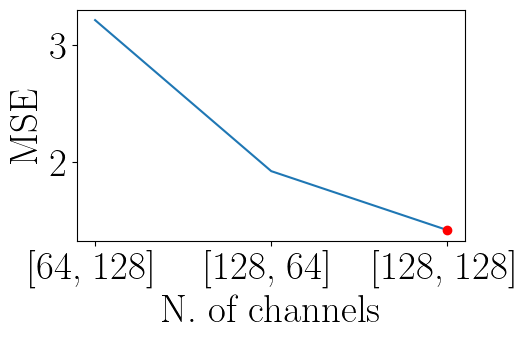

In [23]:
ind_min_ch = np.argmin(val_mse_channels)
plt.figure(figsize=(5,3))
plt.plot(val_mse_channels)
plt.plot(ind_min_ch, val_mse_channels[ind_min_ch], marker='o', color='red')
plt.xticks(np.arange(len(channels)), channels)
plt.xlabel('N. of channels')
plt.ylabel('MSE')
plt.show()

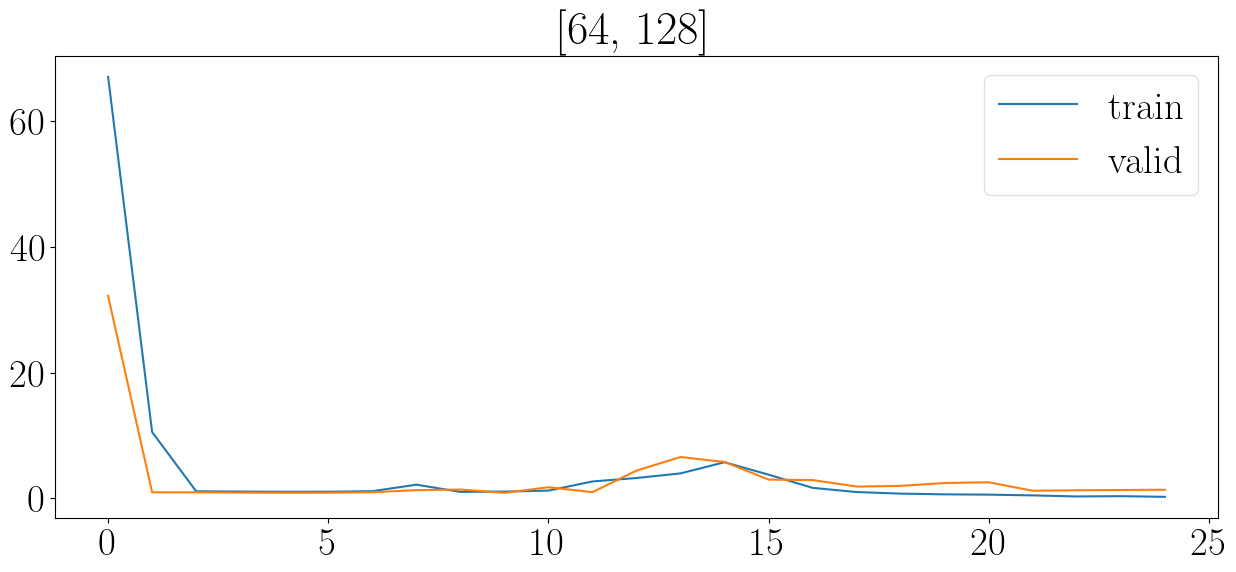

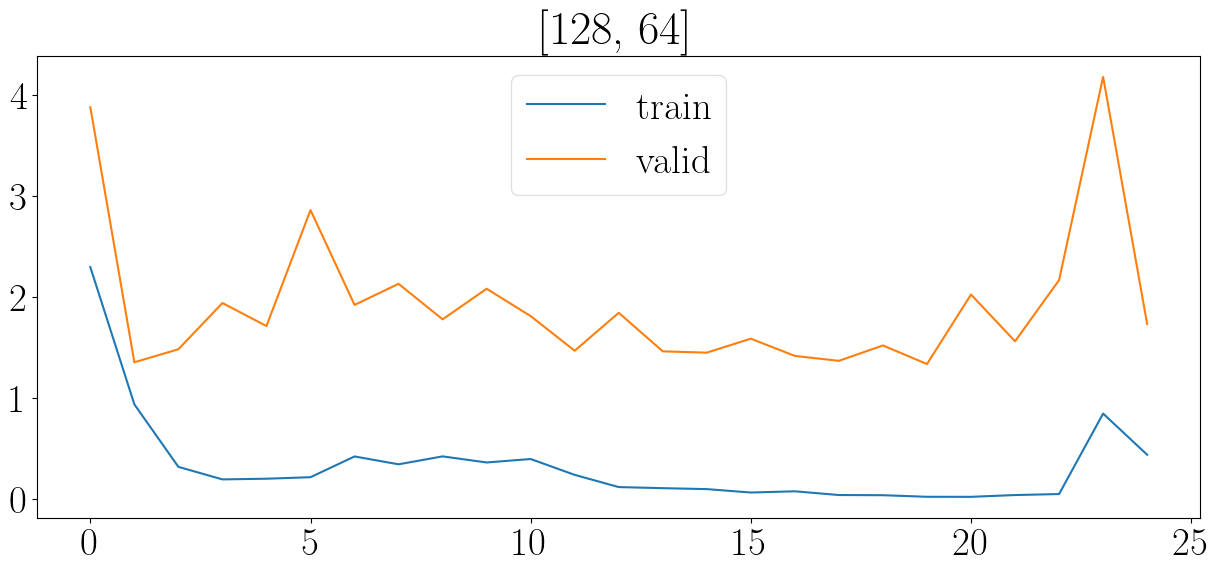

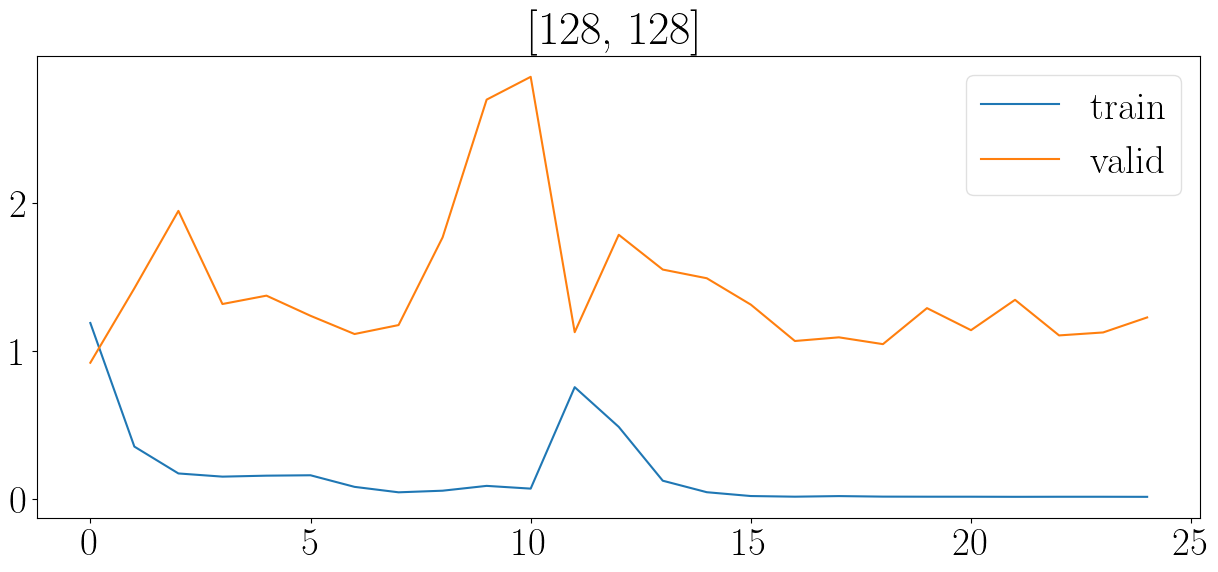

In [25]:
for i in range(len(train_losses)):
    plt.plot(train_losses[i], label='train')
    plt.plot(val_losses[i], label='valid')
    plt.title(str(channels[i]))
    plt.legend()
    plt.show()

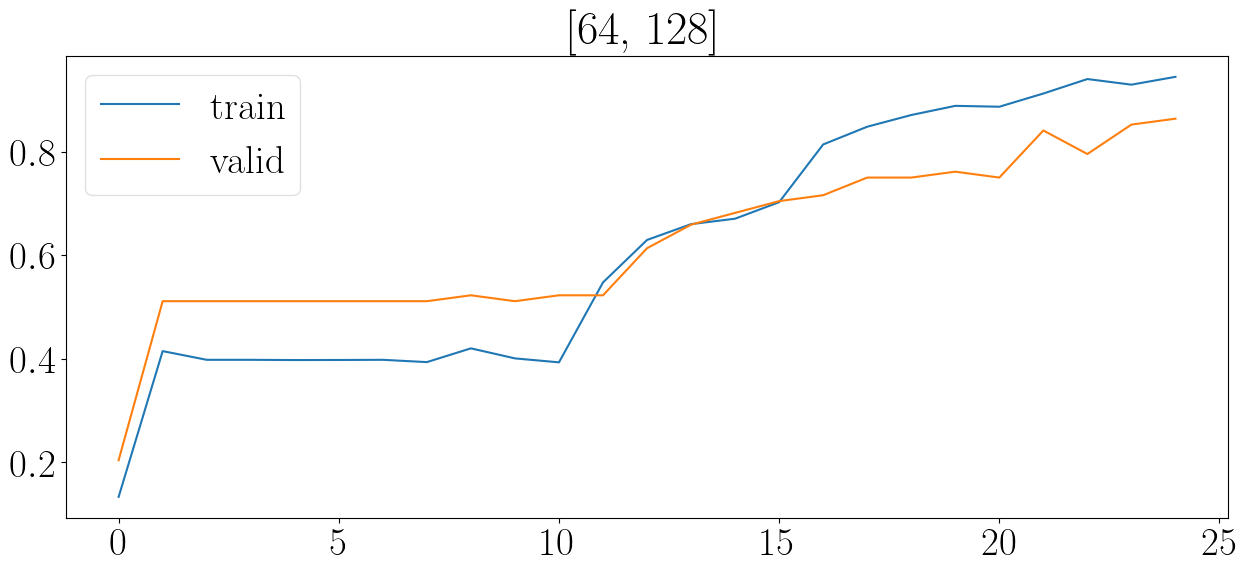

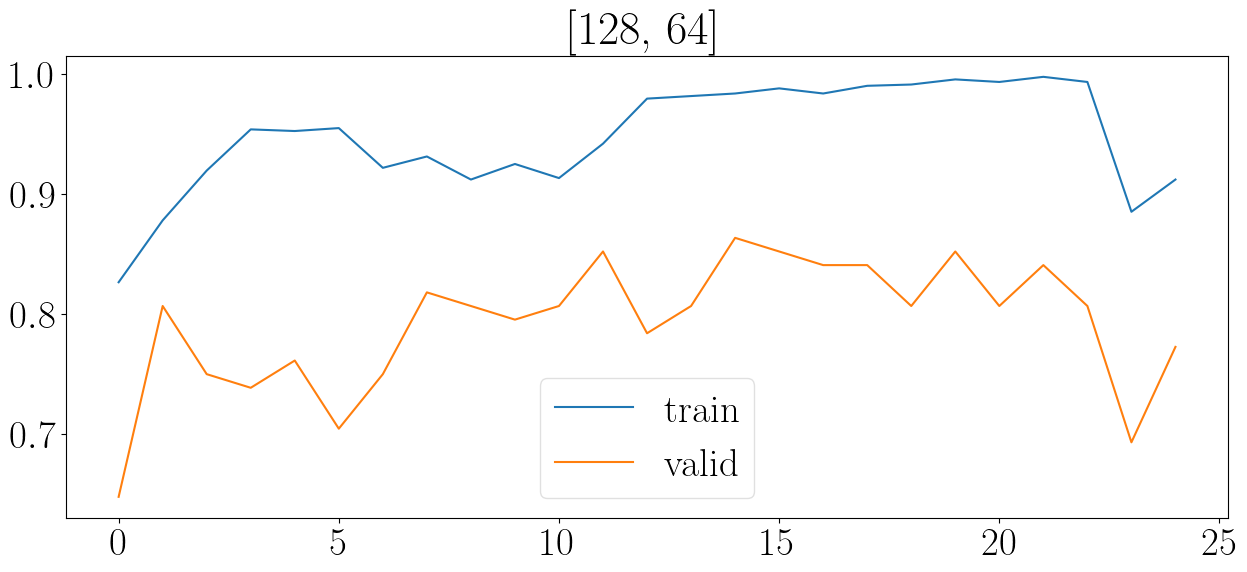

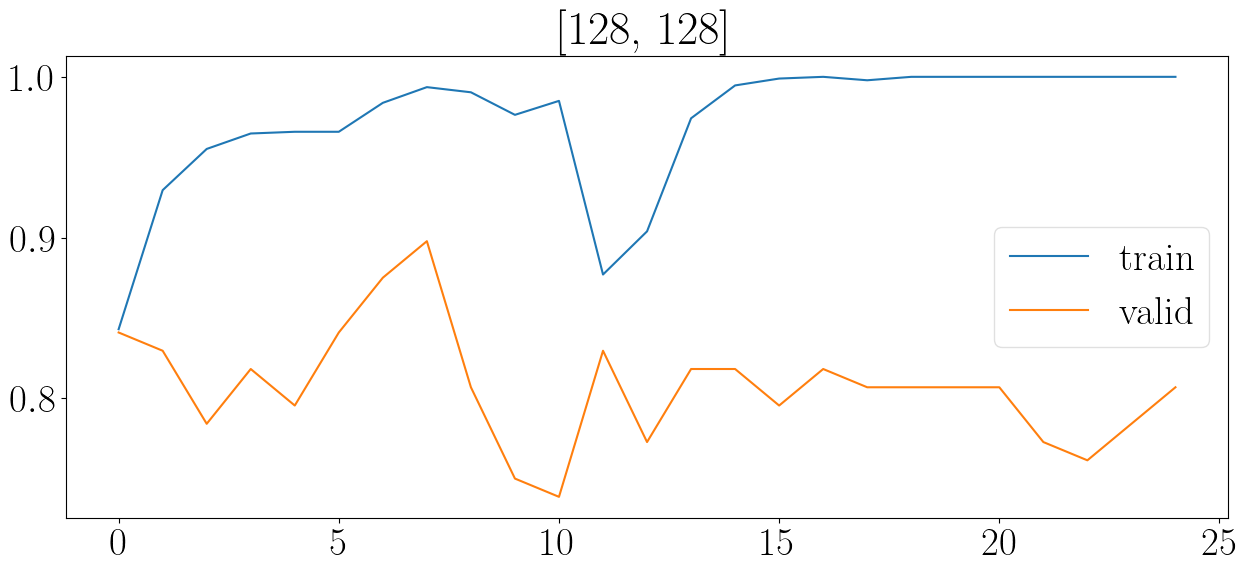

In [24]:
for i in range(len(train_accs)):
    plt.plot(train_accs[i], label='train')
    plt.plot(val_accs[i], label='valid')
    plt.title(str(channels[i]))
    plt.legend()
    plt.show()

### 3. Kernel size

In [11]:
autoencoder = autoencoder.cpu()
net = net.cpu()

del autoencoder, optimizer, net
torch.cuda.empty_cache()

In [ ]:
kernel_dic = {(1,1,3): [0,0,1], (1,1,5): [0,0,2], (1,1,7): [0,0,3], (1,1,9): [0,0,4]}
val_mse_kernel = []
train_losses, val_losses = [], []
train_accs, val_accs = [], []
cae_losses, snn_losses = [], []

snn =  network.snn_1(
                    input_dim = 2*10*64, hidden = params.params_snn['hidden_layers'], 
                    n_classes = params.params_snn['num_classes'], 
                    surr_grad = params.params_snn['surrogate_grad'],
                    learn_thr = params.params_snn['learn_thr'], 
                    learn_beta = params.params_snn['learn_beta']
                    ).to(device)

for kernel, pad in kernel_dic.items():
    autoencoder = network.cae_3(
                            tau = params_cae['tau'], 
                            channels = params_cae['feature_maps'], 
                            kernel_size = kernel, 
                            stride = params_cae['stride'], padding = pad
                            ).to(device)
    
    net = LSE(autoencoder, snn).to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr = params_train['l_rate'])

    train_loss, val_loss, train_acc, val_acc, cae_loss, snn_loss = train_utils_ext.train(
                                                        model = net, 
                                                        train = train_loader, 
                                                        valid = val_loader,
                                                        loss_fn_cae = params_cae['loss_fn'], 
                                                        out_dec = params_snn['output_decoding'],
                                                        optimizer = optimizer, 
                                                        acc_steps = params_train['acc_steps'],
                                                        alfa = params_train['alpha'], 
                                                        beta = params_train['beta'], 
                                                        Lambda = params_train['lambda_reg'], 
                                                        epochs = params_train['epochs'], 
                                                        patience = params_train['patience'], 
                                                        path = None)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    cae_losses.append(cae_loss)
    snn_losses.append(snn_loss)
    val_mse_kernel.append(np.mean(val_loss))

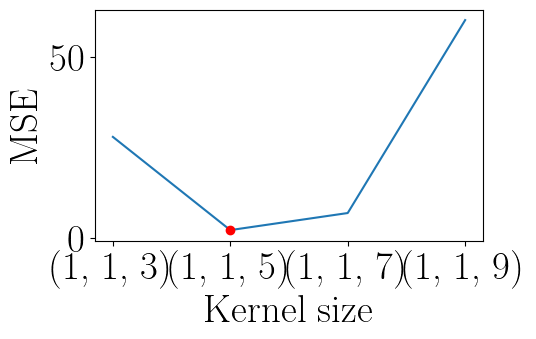

In [16]:
ind_min_ker = np.argmin(val_mse_kernel)
plt.figure(figsize=(5,3))
plt.plot(val_mse_kernel)
plt.plot(ind_min_ker, val_mse_kernel[ind_min_ker], marker='o', color='red')
plt.xticks(np.arange(len(kernel_dic)), kernel_dic.keys())
plt.xlabel('Kernel size')
plt.ylabel('MSE')
plt.show()

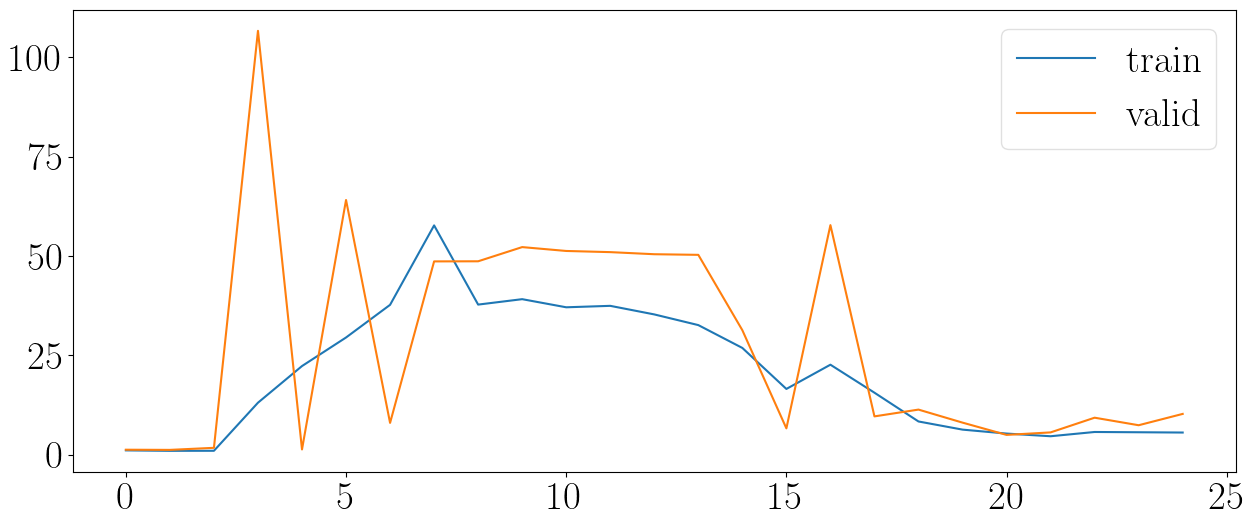

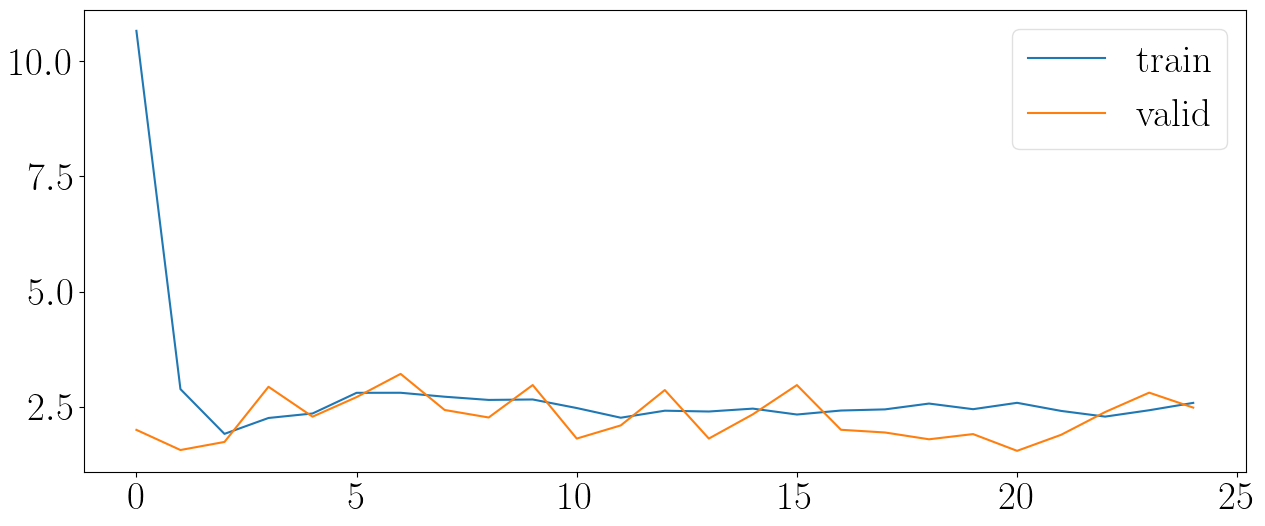

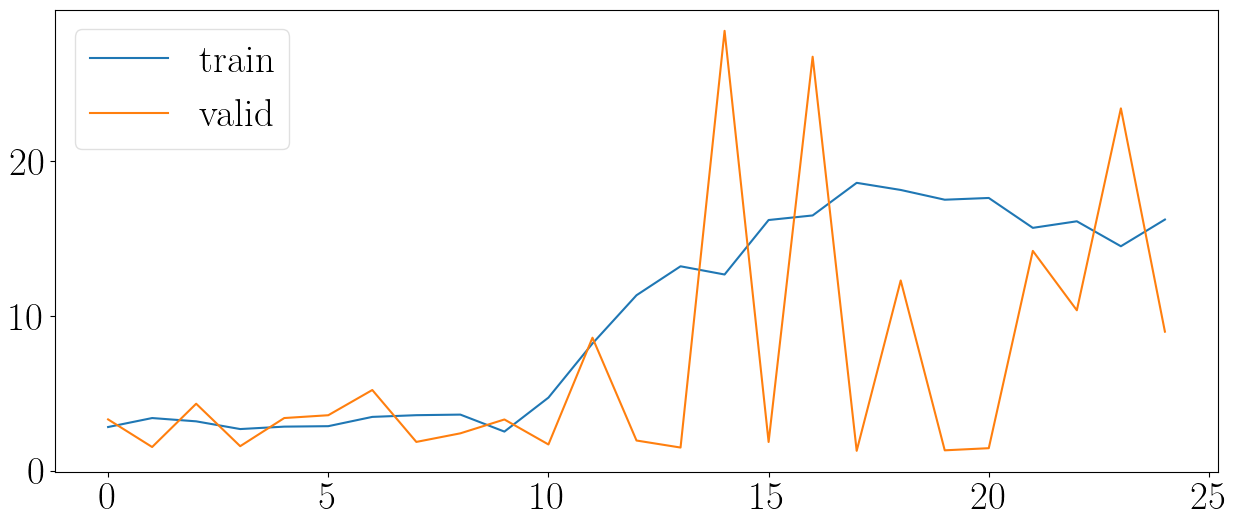

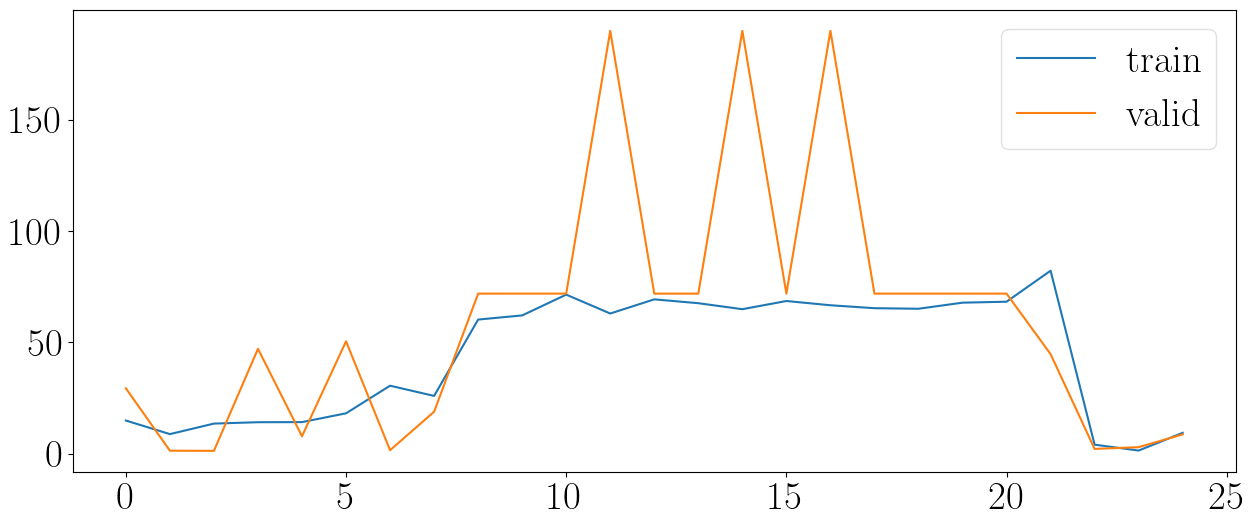

In [18]:
for i in range(len(train_losses)):
    plt.plot(train_losses[i], label='train')
    plt.plot(val_losses[i], label='valid')
    #plt.title(str(channels[i]))
    plt.legend()
    plt.show()

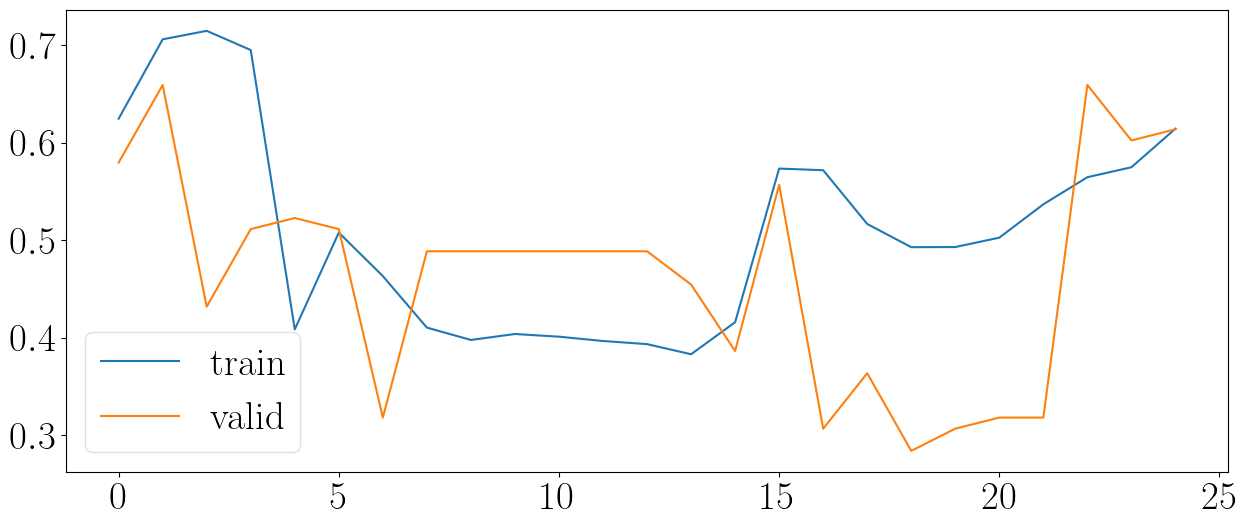

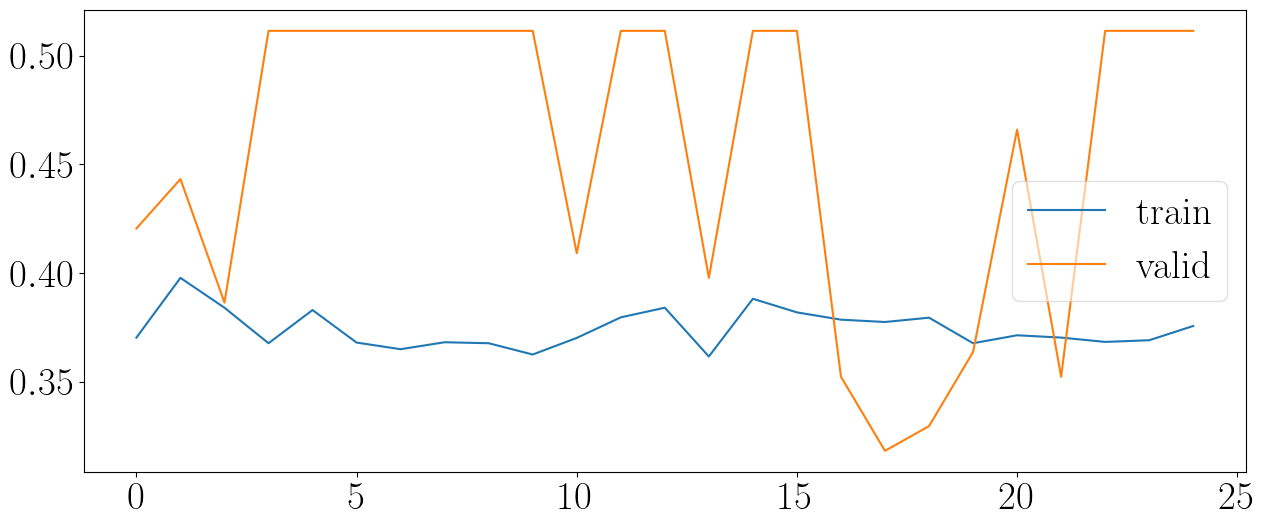

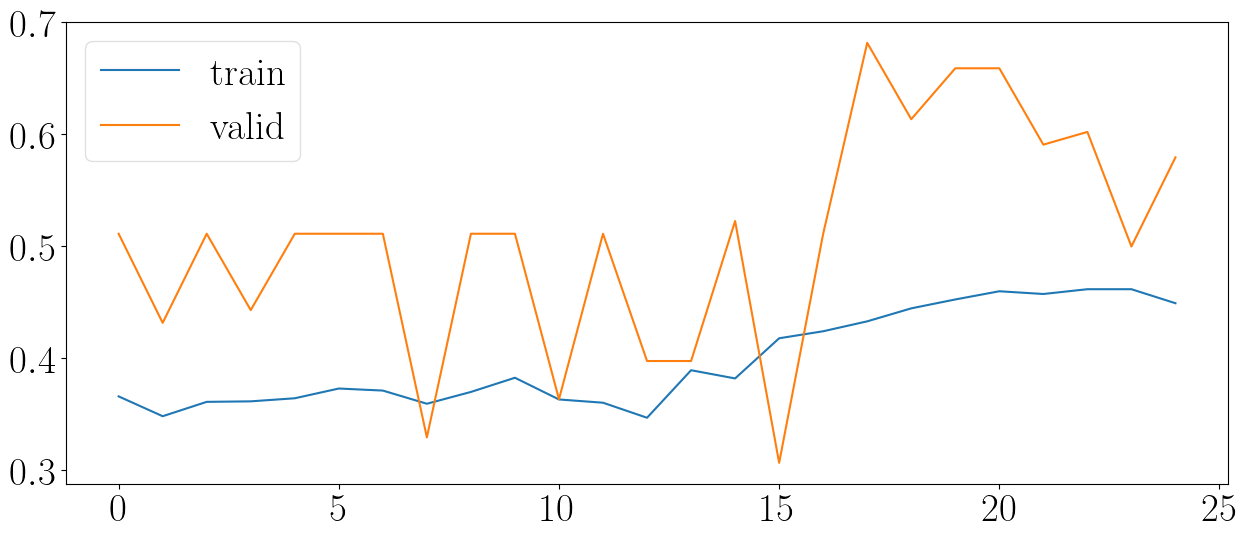

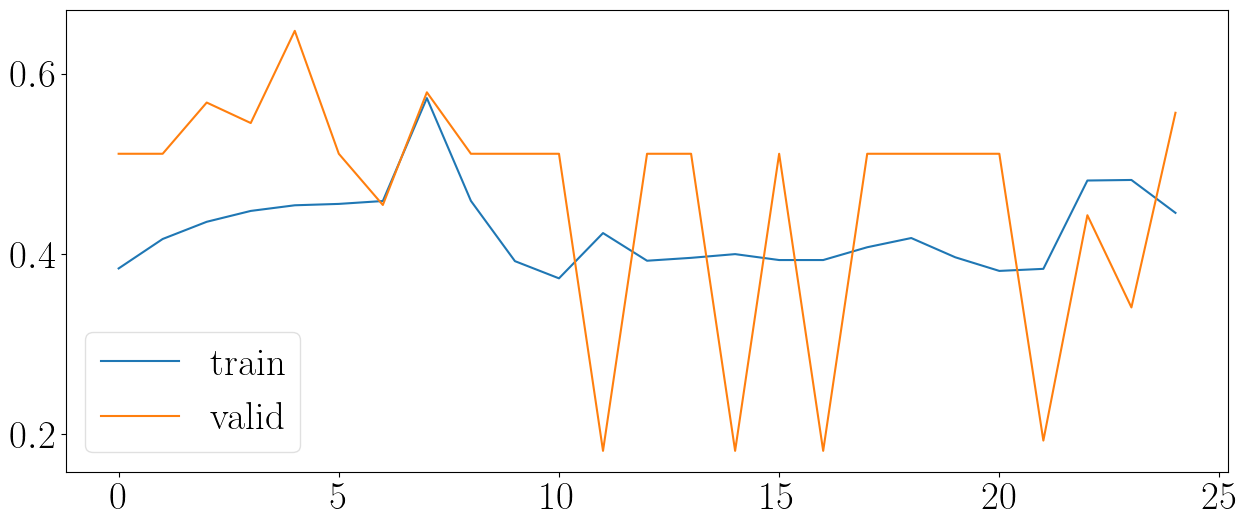

In [20]:
for i in range(len(train_accs)):
    plt.plot(train_accs[i], label='train')
    plt.plot(val_accs[i], label='valid')
    #plt.title(str(channels[i]))
    plt.legend()
    plt.show()

### 4. Threshold $\tau$

In [ ]:
tau_values = np.arange(0.1, 1.0, 0.2)

val_mse_tau = []
train_losses, val_losses = [], []
train_accs, val_accs = [], []
cae_losses, snn_losses = [], []

snn =  network.snn_1(
                    input_dim = 2*10*64, hidden = params_snn['hidden_layers'], 
                    n_classes = params_snn['num_classes'], 
                    surr_grad = params_snn['surrogate_grad'],
                    learn_thr = params_snn['learn_thr'], 
                    learn_beta = params_snn['learn_beta']
                    ).to(device)

for tau in tau_values:
    autoencoder = network.cae_3(
                            tau = tau, 
                            channels = params_cae['feature_maps'], 
                            kernel_size = params_cae['kernel'], 
                            stride = params_cae['stride'], 
                            padding = params_cae['padding']
                            ).to(device)
    
    net = LSE(autoencoder, snn).to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr = params_train['l_rate'])

    train_loss, val_loss, train_acc, val_acc, cae_loss, snn_loss = train_utils_ext.train(
                                                        model = net, 
                                                        train = train_loader, 
                                                        valid = val_loader,
                                                        loss_fn_cae = params_cae['loss_fn'], 
                                                        out_dec = params_snn['output_decoding'],
                                                        optimizer = optimizer, 
                                                        acc_steps = params_train['acc_steps'],
                                                        alfa = params_train['alpha'], 
                                                        beta = params_train['beta'], 
                                                        Lambda = params_train['lambda_reg'], 
                                                        epochs = params_train['epochs'], 
                                                        patience = params_train['patience'], 
                                                        path = None)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    cae_losses.append(cae_loss)
    snn_losses.append(snn_loss)
    val_mse_tau.append(np.mean(val_loss))

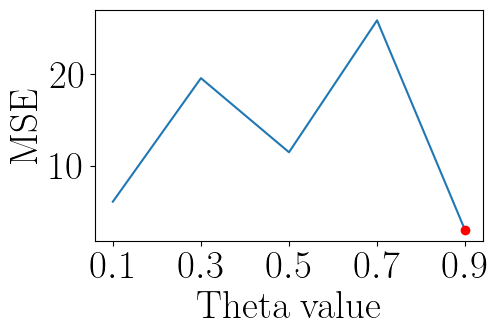

In [11]:
ind_min_tau = np.argmin(val_mse_tau)
plt.figure(figsize=(5,3))
plt.plot(tau_values, val_mse_tau)
plt.plot(tau_values[ind_min_tau], val_mse_tau[ind_min_tau], marker='o', color='red')
plt.xticks(tau_values)
plt.xlabel('Tau value')
plt.ylabel('MSE')
plt.show()

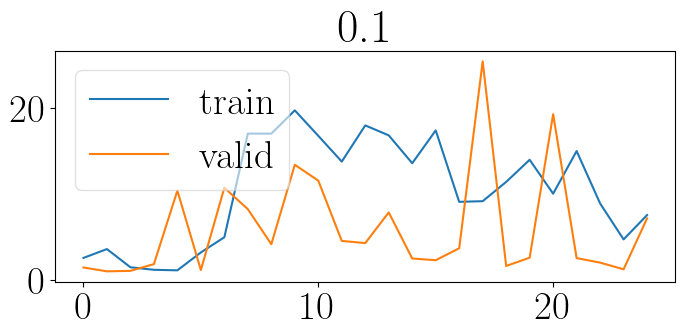

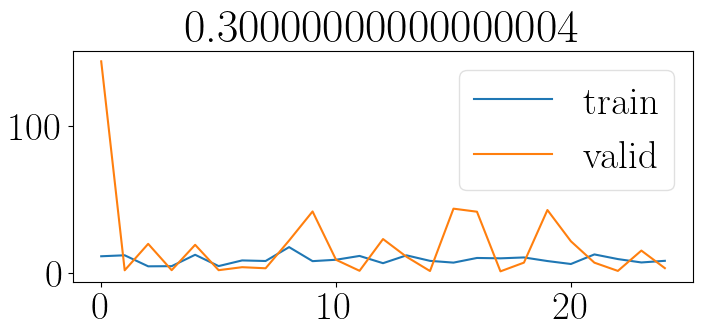

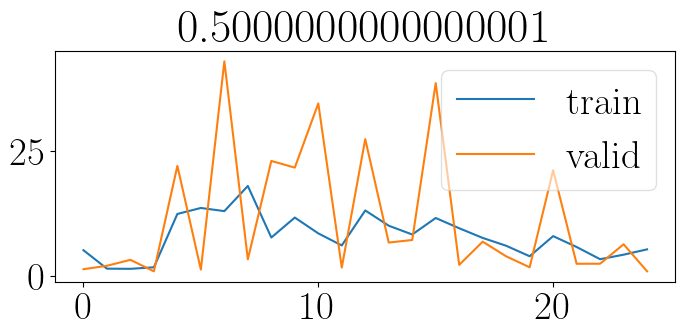

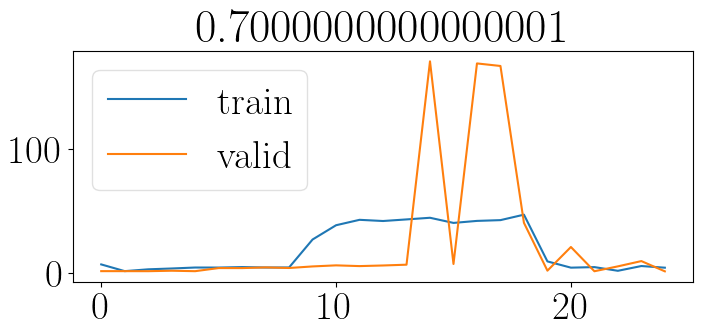

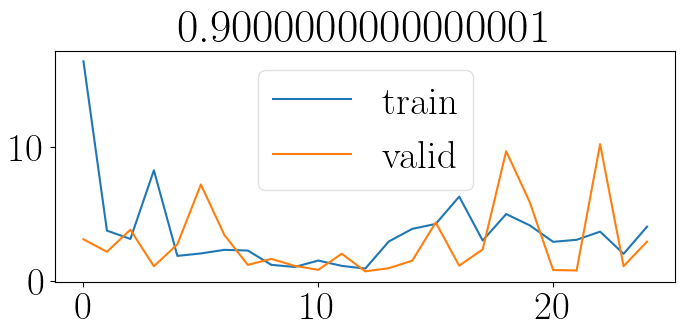

In [17]:
for i in range(len(train_losses)):
    plt.figure(figsize=(8,3))
    plt.plot(train_losses[i], label='train')
    plt.plot(val_losses[i], label='valid')
    plt.title(str(theta_values[i]))
    plt.legend()
    plt.show()

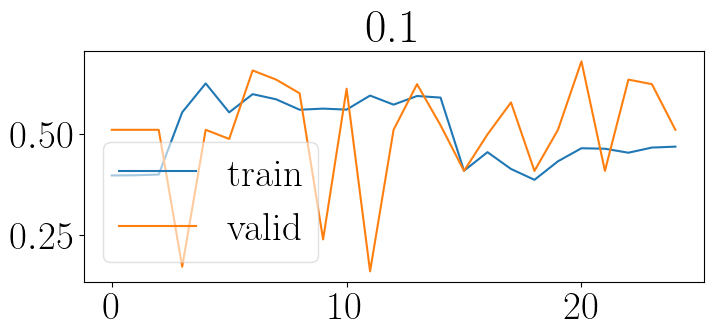

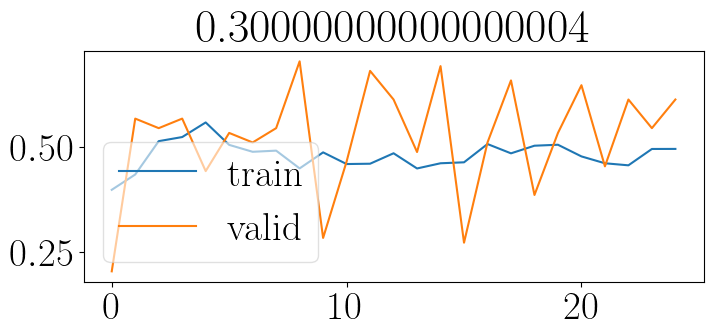

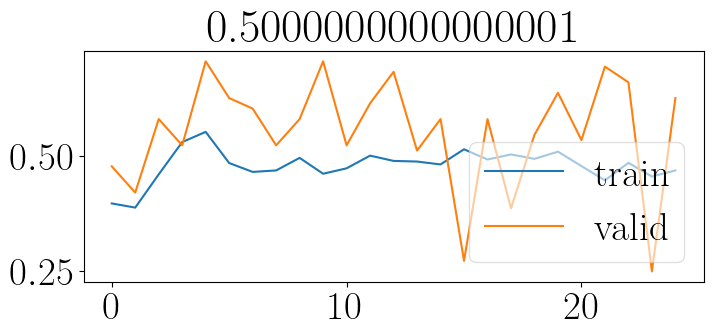

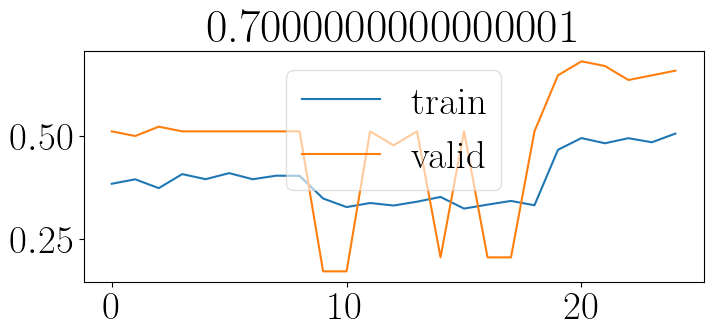

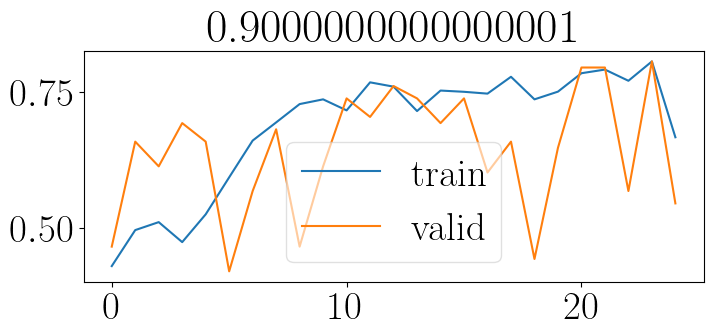

In [18]:
for i in range(len(train_accs)):
    plt.figure(figsize=(8,3))
    plt.plot(train_accs[i], label='train')
    plt.plot(val_accs[i], label='valid')
    plt.title(str(tau_values[i]))
    plt.legend()
    plt.show()

### 5. $\alpha$ e $\beta$

In [ ]:
alpha_values = np.array([0.99, 0.9, 0.85, 0.5])
beta_values = 1-alpha_values

val_mse_ab = []
train_losses, val_losses = [], []
train_accs, val_accs = [], []
cae_losses, snn_losses = [], []

snn =  network.snn_1(
                    input_dim = 2*10*64, hidden = params_snn['hidden_layers'], 
                    n_classes = params_snn['num_classes'], 
                    surr_grad = params_snn['surrogate_grad'],
                    learn_thr = params_snn['learn_thr'], 
                    learn_beta = params_snn['learn_beta']
                    ).to(device)

for alpha, beta in zip(alpha_values, beta_values):
    autoencoder = network.cae_3(
                            tau = params_cae['tau'], 
                            channels = params_cae['feature_maps'], 
                            kernel_size = params_cae['kernel'], 
                            stride = params_cae['stride'], 
                            padding = params_cae['padding']
                            ).to(device)
    
    net = LSE(autoencoder, snn).to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr = params_train['l_rate'])

    train_loss, val_loss, train_acc, val_acc, cae_loss, snn_loss = train_utils_ext.train(
                                                        model = net, 
                                                        train = train_loader, 
                                                        valid = val_loader,
                                                        loss_fn_cae = params_cae['loss_fn'], 
                                                        out_dec = params_snn['output_decoding'],
                                                        optimizer = optimizer, 
                                                        acc_steps = params_train['acc_steps'],
                                                        alfa = alpha, 
                                                        beta = beta, 
                                                        Lambda = params_train['lambda_reg'], 
                                                        epochs = params_train['epochs'], 
                                                        patience = params_train['patience'], 
                                                        path = None)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    cae_losses.append(cae_loss)
    snn_losses.append(snn_loss)
    val_mse_ab.append(np.mean(val_loss))

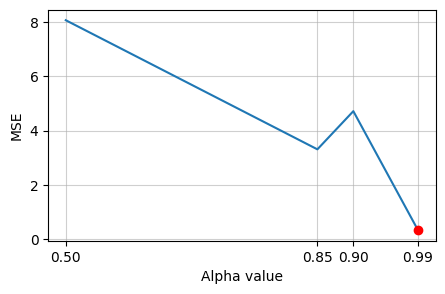

In [111]:
ind_min_ab = np.argmin(val_mse_ab)
plt.figure(figsize=(5,3))
plt.plot(alpha_values, val_mse_ab)
plt.plot(alpha_values[ind_min_ab], val_mse_ab[ind_min_ab], marker='o', color='red')
plt.xticks(alpha_values)
plt.xlabel('Alpha value')
plt.ylabel('MSE')
plt.grid(alpha=.6)
plt.show()

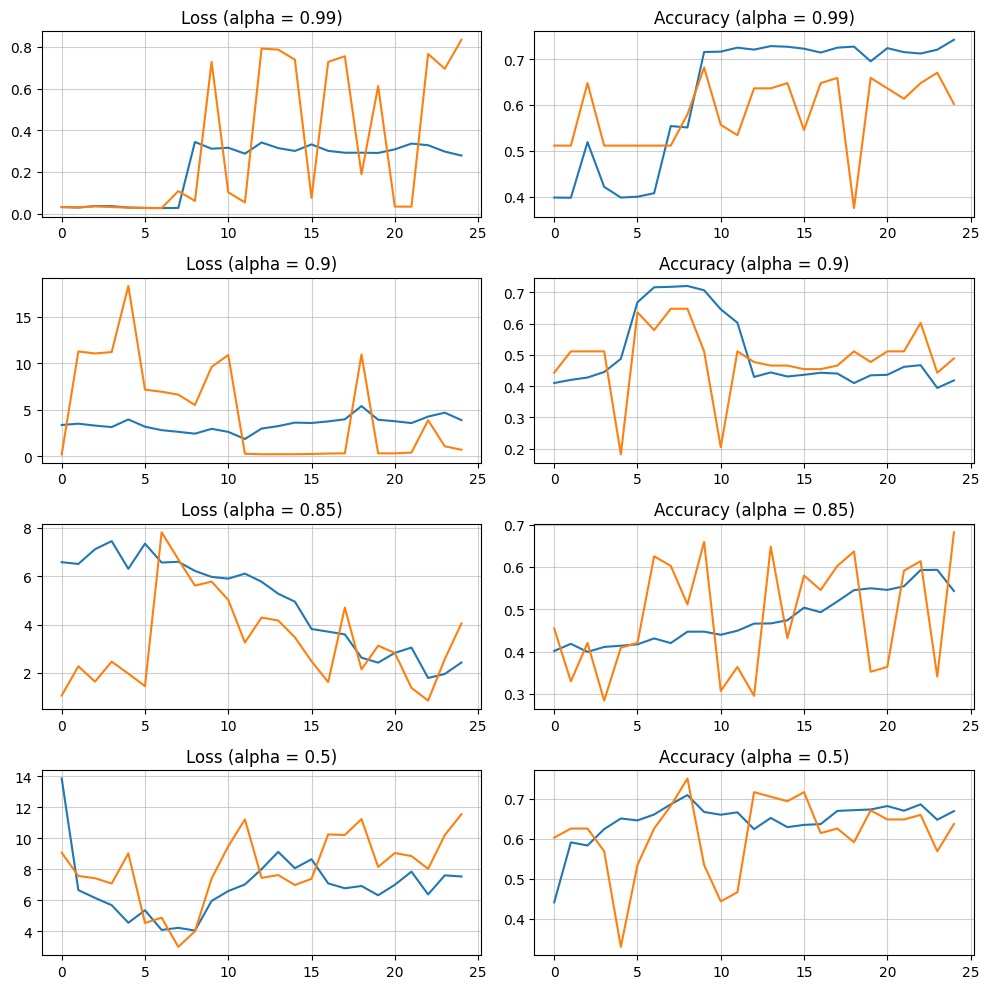

In [110]:
fig, axes = plt.subplots(len(alpha_values),2, figsize=(10,10)) 

for i, ax in enumerate(axes):
    ax[0].plot(train_losses[i], label='train')
    ax[0].plot(val_losses[i], label='valid')
    ax[0].set_title(f"Loss (alpha = {str(alpha_values[i])})")
    ax[0].grid(alpha=.6)
    ax[1].plot(train_accs[i], label='train')
    ax[1].plot(val_accs[i], label='valid')
    ax[1].set_title(f"Accuracy (alpha = {str(alpha_values[i])})")
    ax[1].grid(alpha=.6)

plt.tight_layout()
plt.show()

### 6. Sparsity regularization

In [ ]:
lambda_reg = np.arange(0.0, 1.1, 0.1)

val_mse_reg, sparsity = [], []
train_losses, val_losses = [], []
train_accs, val_accs = [], []
cae_losses, snn_losses = [], []


snn =  network.snn_1(
                    input_dim = 2*10*64, hidden = params_snn['hidden_layers'], 
                    n_classes = params_snn['num_classes'], 
                    surr_grad = params_snn['surrogate_grad'],
                    learn_thr = params_snn['learn_thr'], 
                    learn_beta = params_snn['learn_beta']
                    ).to(device)

for lambda_ in lambda_reg:
    autoencoder = network.cae_3(
                        tau = params_cae['tau'], 
                        channels = params_cae['feature_maps'], 
                        kernel_size = params_cae['kernel'], 
                        stride = params_cae['stride'], 
                        padding = params_cae['padding']
                        ).to(device)
    
    net = LSE(autoencoder, snn).to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr = params_train['l_rate'])

    train_loss, val_loss, train_acc, val_acc, cae_loss, snn_loss = train_utils_ext.train(
                                                        model = net, 
                                                        train = train_loader, 
                                                        valid = val_loader,
                                                        loss_fn_cae = params_cae['loss_fn'], 
                                                        out_dec = params_snn['output_decoding'],
                                                        optimizer = optimizer, 
                                                        acc_steps = params_train['acc_steps'],
                                                        alfa = params_train['alpha'], 
                                                        beta = params_train['beta'], 
                                                        Lambda = lambda_, 
                                                        epochs = params_train['epochs'], 
                                                        patience = params_train['patience'], 
                                                        path = None)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    cae_losses.append(cae_loss)
    snn_losses.append(snn_loss)
    val_mse_reg.append(np.mean(val_loss))

    net.eval()
    with torch.no_grad():
        spars = 0

        for X, _, _ in val_loader:
            X = X.to(device)
            spike = net(X.float())[0]
            spars += 1 - torch.mean(abs(spike))
        sparsity.append(spars.cpu().numpy()/len(val_loader))

In [11]:
metrics = pd.DataFrame({'Lambda': lambda_reg, 'Sparsity': sparsity, 'Error': val_mse_reg})

display(metrics)

,Lambda,Sparsity,Error
0,0.0,0.045663,0.056809
1,0.1,0.663867,0.082245
2,0.2,0.583912,0.111323
3,0.3,0.731067,0.152974
4,0.4,0.676541,0.177499
5,0.5,0.758422,0.193558
6,0.6,0.767129,0.229310
7,0.7,0.764885,0.264303
8,0.8,0.756624,0.299085
9,0.9,0.749736,0.296867


In [8]:
metrics.to_csv('Sparsity_vs_error_2.csv')

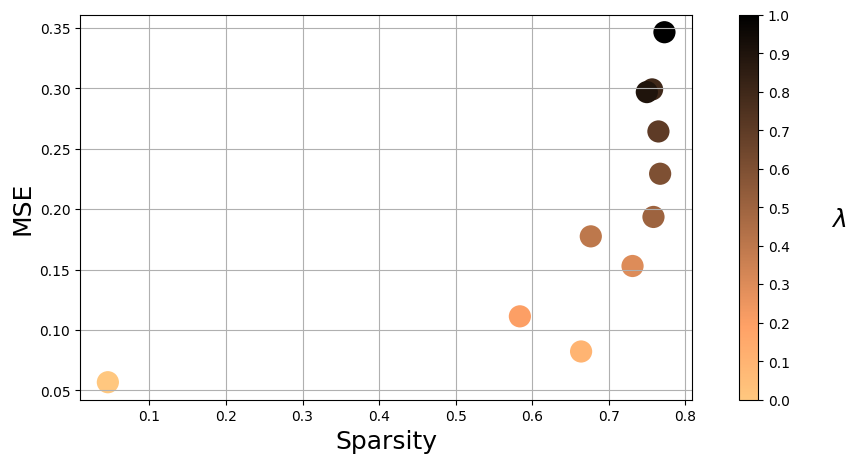

In [14]:
plt.figure(figsize=(10,5))
plt.scatter(sparsity, val_mse_reg, cmap=plt.colormaps.get_cmap('copper_r'),
            c=lambda_reg, linewidths=10)
plt.xlabel("Sparsity", fontsize=18)
plt.ylabel("MSE", fontsize=18)
#plt.xticks(np.arange(0.2,0.9, 0.2))
#plt.yticks([0.08, 0.09, 0.1])
plt.grid()
colorbar = plt.colorbar(pad=0.06)#, location='top', orientation='horizontal')
colorbar.set_label(r'$\lambda$', labelpad=35, rotation=0, fontsize=18)
#colorbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])
colorbar.set_ticks(lambda_reg)
#colorbar.set_ticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
colorbar.set_ticklabels(np.round(lambda_reg,1))
plt.show()

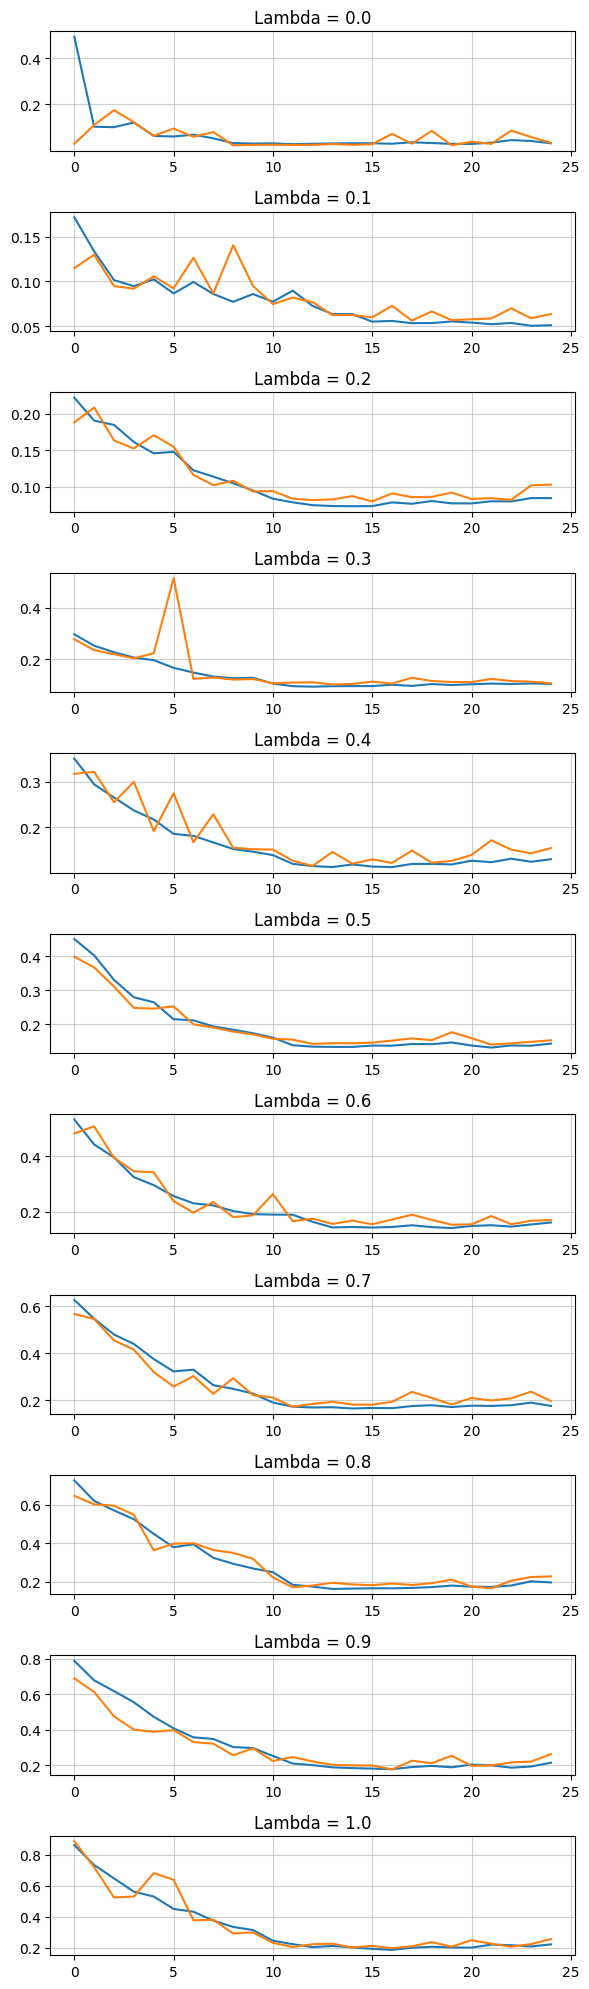

In [10]:
fig, axes = plt.subplots(len(lambda_reg),1, figsize=(6,20)) 

for i, ax in enumerate(axes):
    ax.plot(train_losses[i], label='train')
    ax.plot(val_losses[i], label='valid')
    ax.set_title(f"Lambda = {str(round(lambda_reg[i],1))}")
    ax.grid(alpha=.6)

plt.tight_layout()
plt.show()

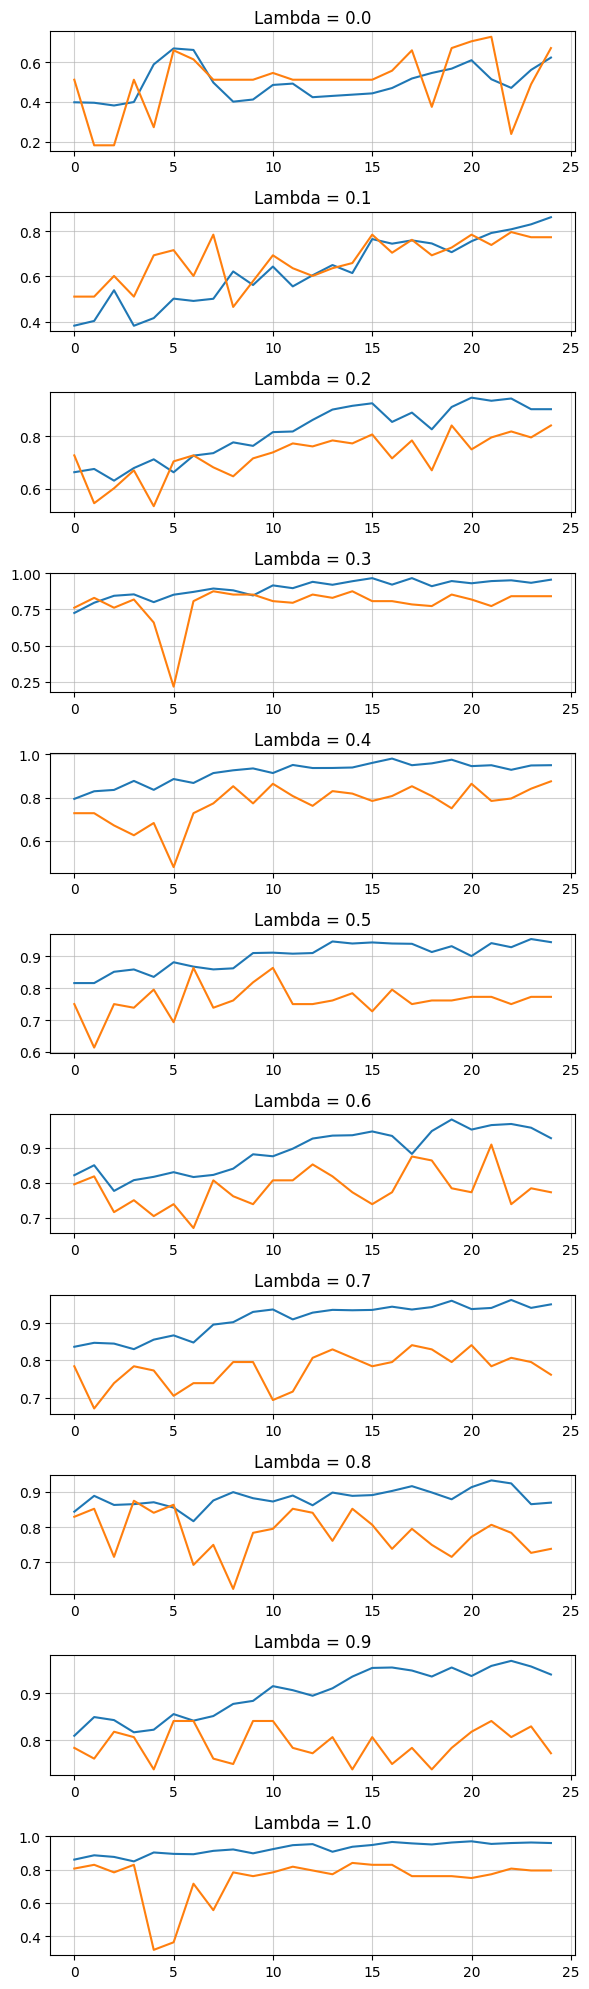

In [15]:
fig, axes = plt.subplots(len(lambda_reg),1, figsize=(6,20)) 

for i, ax in enumerate(axes):
    ax.plot(train_accs[i], label='train')
    ax.plot(val_accs[i], label='valid')
    ax.set_title(f"Lambda = {str(round(lambda_reg[i],1))}")
    ax.grid(alpha=.6)

plt.tight_layout()
plt.show()

### 7. Number of SNN layers

In [10]:
val_mse_snn_layers = []
train_losses, val_losses = [], []
train_accs, val_accs = [], []
cae_losses, snn_losses = [], []

autoencoder = network.cae_3(
                        tau = params_cae['tau'], 
                        channels = params_cae['feature_maps'], 
                        kernel_size = params_cae['kernel'], 
                        stride = params_cae['stride'], 
                        padding = params_cae['padding']
                        ).to(device)

### 2 hidden layers
snn =  network.snn_2(
                    input_dim = 2*10*64, hidden = params_snn['hidden_layers'], 
                    n_classes = params_snn['num_classes'], 
                    surr_grad = params_snn['surrogate_grad'],
                    learn_thr = params_snn['learn_thr'], 
                    learn_beta = params_snn['learn_beta']
                    ).to(device)
    
net = LSE(autoencoder, snn).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr = params_train['l_rate'])

train_loss, val_loss, train_acc, val_acc, cae_loss, snn_loss = train_utils_ext.train(
                                                        model = net, 
                                                        train = train_loader, 
                                                        valid = val_loader,
                                                        loss_fn_cae = params_cae['loss_fn'], 
                                                        out_dec = params_snn['output_decoding'],
                                                        optimizer = optimizer, 
                                                        acc_steps = params_train['acc_steps'],
                                                        alfa = params_train['alpha'], 
                                                        beta = params_train['beta'], 
                                                        Lambda = params_train['lambda_reg'], 
                                                        epochs = params_train['epochs'], 
                                                        patience = params_train['patience'], 
                                                        path = None)
train_losses.append(train_loss)
val_losses.append(val_loss)
train_accs.append(train_acc)
val_accs.append(val_acc)
cae_losses.append(cae_loss)
snn_losses.append(snn_loss)
val_mse_snn_layers.append(np.mean(val_loss))

### 3 hidden layers
snn =  network.snn_2(
                    input_dim = 2*10*64, hidden = params_snn['hidden_layers'], 
                    n_classes = params_snn['num_classes'], 
                    surr_grad = params_snn['surrogate_grad'],
                    learn_thr = params_snn['learn_thr'], 
                    learn_beta = params_snn['learn_beta']
                    ).to(device)
    
net = LSE(autoencoder, snn).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr = params_train['l_rate'])

train_loss, val_loss, train_acc, val_acc, cae_loss, snn_loss = train_utils_ext.train(
                                                        model = net, 
                                                        train = train_loader, 
                                                        valid = val_loader,
                                                        loss_fn_cae = params_cae['loss_fn'], 
                                                        out_dec = params_snn['output_decoding'],
                                                        optimizer = optimizer, 
                                                        acc_steps = params_train['acc_steps'],
                                                        alfa = params_train['alpha'], 
                                                        beta = params_train['beta'], 
                                                        Lambda = params_train['lambda_reg'], 
                                                        epochs = params_train['epochs'], 
                                                        patience = params_train['patience'], 
                                                        path = None)
train_losses.append(train_loss)
val_losses.append(val_loss)
train_accs.append(train_acc)
val_accs.append(val_acc)
cae_losses.append(cae_loss)
snn_losses.append(snn_loss)
val_mse_snn_layers.append(np.mean(val_loss))

FileNotFoundError: Caught FileNotFoundError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "C:\Users\root\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\_utils\worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
           ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\root\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\_utils\fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\root\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\_utils\fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "c:\Users\root\Desktop\Papers\Learned-Spike-Encoding\dataset.py", line 262, in __getitem__
    with open(
         ^^^^^
FileNotFoundError: [Errno 2] No such file or directory: '.\\data\\processed_data\\0_4_RUNNING_2_1.obj'


In [ ]:
ind_min_snn_l = np.argmin(val_mse_snn_layers)
plt.figure(figsize=(5,3))
plt.plot(val_mse_snn_layers)
plt.plot(val_mse_snn_layers[ind_min_snn_l], marker='o', color='red')
plt.xticks([2,3])
plt.xlabel('SNN layers')
plt.ylabel('MSE')
plt.grid(alpha=.6)
plt.show()

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(10,10)) 

for i, ax in enumerate(axes):
    ax[0].plot(train_losses[i], label='train')
    ax[0].plot(val_losses[i], label='valid')
    ax[0].set_title(f"Loss (2 SNN layers)")
    ax[0].grid(alpha=.6)
    ax[1].plot(train_accs[i], label='train')
    ax[1].plot(val_accs[i], label='valid')
    ax[1].set_title(f"Accuracy (3 SNN layers)")
    ax[1].grid(alpha=.6)

plt.tight_layout()
plt.show()

### 6. Learning rate $\eta$

In [69]:
theta = 0.1
lambda_reg = 0.2
ch = [128, 128]

learning_rates = [1e-4, 1e-3, 1e-2]
mse_values_lr = []

for eta in learning_rates:
    autoencoder_bipolar = network.cae_3(theta=theta, channels= ch,  
                                        kernel_size=k, padding=kernel_dic[k]).to(device)
    
    net = LSE(autoencoder_bipolar, snn).to(device)

    optimizer = torch.optim.Adam(net.parameters(), lr=eta)

    train_loss, val_loss = train_utils_ext.train(net, train_loader, val_loader, loss_cae,
                                                 optimizer, lambda_reg, epochs, patience, None)

    mse_values_lr.append(train_utils_ext.evaluate(net, val_loader, loss_cae))

  0%|          | 0/50 [00:00<?, ?it/s]

 94%|█████████▍| 47/50 [26:32<01:41, 33.88s/it]

Early stopping at epoch 47



 76%|███████▌  | 38/50 [18:46<05:55, 29.64s/it]

Early stopping at epoch 38


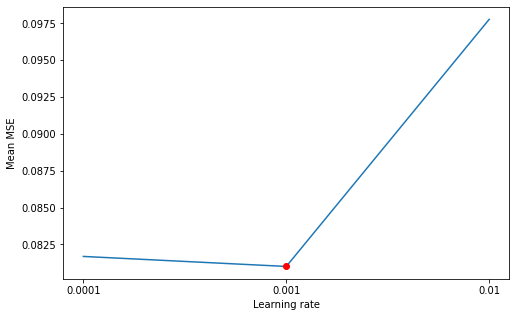

In [70]:
ind_min_lr = np.argmin(mse_values_lr)
plt.figure(figsize=(8,5))
plt.plot(mse_values_lr)
plt.plot(ind_min_lr,  mse_values_lr[ind_min_lr], marker='o', color='red')
plt.xticks([0, 1, 2], learning_rates)
plt.xlabel('Learning rate')
plt.ylabel('Mean MSE')
plt.show()

### 7. Optimization algorithm

In [73]:
eta = 1e-3
theta = 0.9
lambda_reg = 0.2

mse_values_opt = []

autoencoder_bipolar = network.cae_3(theta=theta, kernel_size=7, 
                                                channels=[128, 256], padding=3).to(device)

net = LSE(autoencoder_bipolar, snn).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=eta)

train_loss, val_loss = train_utils_ext.train(net, train_loader, val_loader,
                                                loss_cae, optimizer, lambda_reg, epochs)

mse_values_opt.append(train_utils_ext.evaluate(net, val_loader, loss_cae))

################################################################################################

optimizer = torch.optim.SGD(net.parameters(), lr=eta)

train_loss, val_loss = train_utils_ext.train(net, train_loader, val_loader,
                                                loss_cae, optimizer, lambda_reg, epochs)

mse_values_opt.append(train_utils_ext.evaluate(net, val_loader, loss_cae))

100%|██████████| 25/25 [11:53<00:00, 28.56s/it]


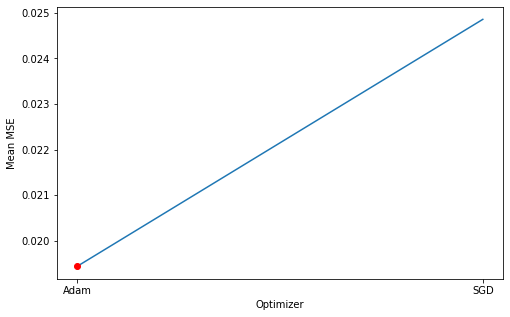

In [74]:
ind_min_opt = np.argmin(mse_values_opt)
plt.figure(figsize=(8,5))
plt.plot(mse_values_opt)
plt.plot(ind_min_opt,  mse_values_opt[ind_min_opt], marker='o', color='red')
plt.xticks([0, 1], ['Adam', 'SGD'])
plt.xlabel('Optimizer')
plt.ylabel('Mean MSE')
plt.show()

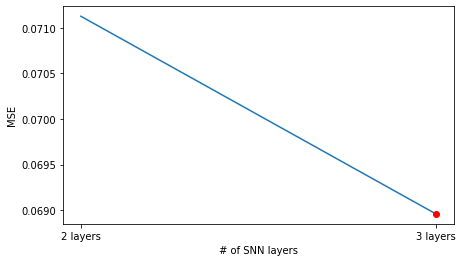

In [72]:
ind_min_nls = np.argmin(val_mse_snn_layers)
plt.figure(figsize=(7,4))
plt.plot(val_mse_snn_layers)
plt.plot(ind_min_nls, val_mse_snn_layers[ind_min_nls], marker='o', color='red')
plt.xticks([0, 1], ['2 layers', '3 layers'])
plt.xlabel('# of SNN layers')
plt.ylabel('MSE')
plt.show()

### 9. Number of LIF neurons

In [74]:
input_channels = 2
hidden_neurons = [[64, 64], [128, 128], [256, 256]]
num_steps = 64
nr_freq = 5
val_mse_neurons = []

autoencoder_bipolar = network.cae_3(theta=theta, channels= ch,  
                                    kernel_size=k, padding=kernel_dic[k]).to(device)


for neurons in hidden_neurons:

    snn =  network.snn_1(input_dim=input_channels, hidden=neurons, n_classes=nr_freq,
                        timesteps=num_steps, surr_grad = surrogate.atan(), learn_thr=True).to(device)

    net = LSE(autoencoder_bipolar, snn).to(device)

    optimizer = torch.optim.Adam(net.parameters(), lr=eta)
    
    train_loss, val_loss = train_utils_ext.train(net, train_loader, val_loader, loss_cae,
                                                 optimizer, lambda_reg, epochs, patience, None)

    val_mse_neurons.append(train_utils_ext.evaluate(net, val_loader, loss_cae))

  0%|          | 0/50 [00:00<?, ?it/s]

 66%|██████▌   | 33/50 [17:14<08:52, 31.34s/it]

Early stopping at epoch 33


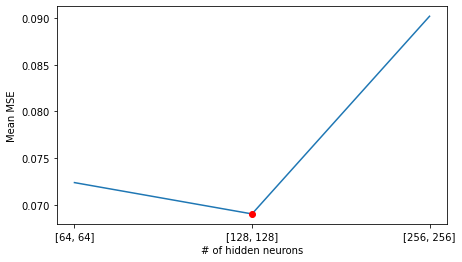

In [75]:
ind_min_neurons = np.argmin(val_mse_neurons)
plt.figure(figsize=(7,4))
plt.plot(val_mse_neurons)
plt.plot(ind_min_neurons, val_mse_neurons[ind_min_neurons], marker='o', color='red')
plt.xticks([0, 1, 2], ['[64, 64]', '[128, 128]', '[256, 256]'])
plt.xlabel('# of hidden neurons')
plt.ylabel('Mean MSE')
plt.show()

In [77]:
input_channels = 2
hidden_neurons = [[128, 64], [64, 128], [128, 128]]
num_steps = 64
nr_freq = 5

val_mse_neurons = []

autoencoder_bipolar = network.cae_3(theta=theta, channels= ch,  
                                    kernel_size=k, padding=kernel_dic[k]).to(device)


for neurons in hidden_neurons:

    snn =  network.snn_1(input_dim=input_channels, hidden=neurons, n_classes=nr_freq,
                     timesteps=num_steps, surr_grad = surrogate.atan(), learn_thr=True).to(device)

    net = LSE(autoencoder_bipolar, snn).to(device)

    optimizer = torch.optim.Adam(net.parameters(), lr=eta)

    train_loss, val_loss = train_utils_ext.train(net, train_loader, val_loader, loss_cae,
                                                 optimizer, lambda_reg, epochs, patience, None)

    val_mse_neurons.append(train_utils_ext.evaluate(net, val_loader, loss_cae))

  0%|          | 0/50 [00:00<?, ?it/s]

 70%|███████   | 35/50 [25:32<10:56, 43.79s/it]

Early stopping at epoch 35


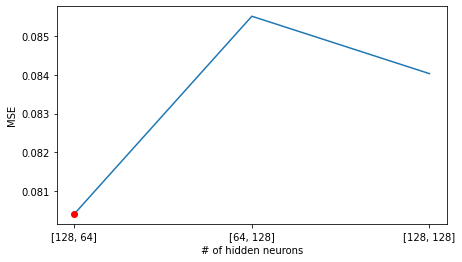

In [78]:
ind_min_neurons = np.argmin(val_mse_neurons)
plt.figure(figsize=(7,4))
plt.plot(val_mse_neurons)
plt.plot(ind_min_neurons, val_mse_neurons[ind_min_neurons], marker='o', color='red')
plt.xticks([0, 1, 2], hidden_neurons)
plt.xlabel('# of hidden neurons')
plt.ylabel('MSE')
plt.show()

### 10. Surrogate gradient

In [83]:
neurons = hidden_neurons[ind_min_neurons]
surr_gradients = [surrogate.atan(), surrogate.fast_sigmoid(), 
                  surrogate.straight_through_estimator()]

val_mse_surr = []

autoencoder_bipolar = network.cae_3(theta=theta, kernel_size=7, 
                                            channels=[128, 256], padding=3).to(device)


for surr_grad in surr_gradients:

    snn =  network.snn_1(input_dim=input_channels, hidden=neurons, n_classes=nr_freq,
                     timesteps=num_steps, surr_grad = surr_grad, learn_thr=True).to(device)

    net = LSE(autoencoder_bipolar, snn).to(device)

    optimizer = torch.optim.Adam(net.parameters(), lr=eta)

    train_loss, val_loss = train_utils_ext.train(net, train_loader, val_loader,
                                                loss_cae, optimizer, lambda_reg, epochs)

    val_mse_surr.append(train_utils_ext.evaluate(net, val_loader, loss_cae))

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [09:19<00:00, 22.40s/it]


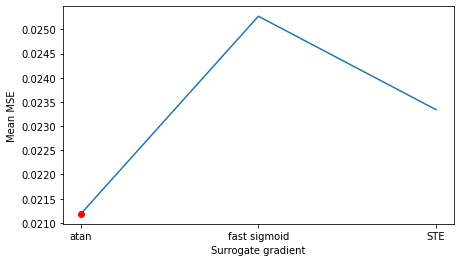

In [84]:
ind_min_surr = np.argmin(val_mse_surr)
plt.figure(figsize=(7,4))
plt.plot(val_mse_surr)
plt.plot(ind_min_surr, val_mse_surr[ind_min_surr], marker='o', color='red')
plt.xticks([0, 1, 2], ['atan', 'fast sigmoid', 'STE'])
plt.xlabel('Surrogate gradient')
plt.ylabel('Mean MSE')
plt.show()

### Train with optimized hyperparams

In [11]:
kernel_dic = {3: 1, 5: 2, 7: 3, 9: 4}
k = 7
theta = 0.1
lambda_reg = 0.2

input_channels = 2
nr_freq = 5
num_steps = 64

eta = 1e-3
patience = 45
epochs = 150
path = "models/net_new1_lambda_0.2.pt"


autoencoder_bipolar = network.cae_3(theta=theta, channels=[128, 128],  
                                    kernel_size=k, padding=kernel_dic[k]).to(device)


snn =  network.snn_1(input_dim=input_channels, hidden= [128, 64], n_classes=nr_freq,
                     timesteps=num_steps, surr_grad = surrogate.atan(), learn_thr=True).to(device)

net = LSE(autoencoder_bipolar, snn).to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=eta)

train_loss_list, val_loss_list = train_utils_ext.train(net, train_loader, val_loader, loss_cae,
                                                       optimizer, lambda_reg, epochs, patience, None)

  0%|          | 0/150 [00:00<?, ?it/s]

 81%|████████▏ | 122/150 [59:17<13:36, 29.16s/it] 

Early stopping at epoch 122


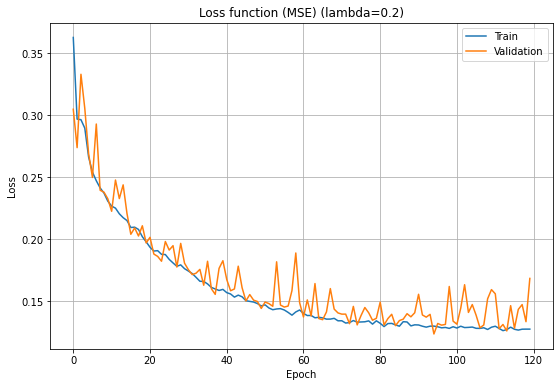

In [85]:
plt.figure(figsize=(9, 6))
plt.plot(train_loss_list, label='Train')
plt.plot(val_loss_list, label='Validation')
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title(f"Loss function (MSE) (lambda={lambda_reg})")
plt.show()